In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from scipy.optimize import differential_evolution
import statsmodels.api as sm
import pickle

In [2]:
#load state_dict
with open('state_dict.pickle', 'rb') as handle:
    state_dict = pickle.load(handle)

In [3]:
# Initialize dictionaries to hold training and testing data
train_dict = {}
test_dict = {}

# Loop over each state
for l in range(51):
    data = state_dict[l]
    
    # Split the data
    train_data = data[:85]   # First 85 rows for training
    test_data = data[85:]    # Remaining 51 rows for testing (since 136 - 85 = 51)
    
    # Store the split data in the dictionaries
    train_dict[l] = train_data
    test_dict[l] = test_data


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def Mob_delay_asy_n2(values, d1, d2, o, alpha):
    df = values.copy()
    df = df.reset_index(drop=True)

    o = round(o)  # Ensure 'o' is an integer

    # Creating shifted columns based on the order 'o'
    for i in range(0, o + 1):
        column_name = f"B_est_{i}"
        df[column_name] = df["case_rate"].astype(float)

    # Applying the delay logic
    for i in range(0, len(df["case_rate"]) - 1):
        if df.loc[i, 'case_rate'] < df.loc[i, f'B_est_{o}']:
            d = d2
        else:
            d = d1

        for j in range(1, o + 1):
            prev_column = f'B_est_{j-1}'
            current_column = f'B_est_{j}'
            df.loc[i + 1, current_column] = df.loc[i, current_column] + (df.loc[i, prev_column] - df.loc[i, current_column]) / (d / o)

    # Preparing the X (independent variable) and y (dependent variable) arrays

    #if cumulative_case_rate is zero then X is zero
    #X = df[f"B_est_{o}"]/df['cumulative_case_rate']**(alpha/100)

    denominator = df['cumulative_case_rate'].copy()
    denominator[denominator == 0] = 1
    X = df[f"B_est_{o}"] / (denominator ** (alpha / 100))

    y = np.log(df['mobility']).values

    #X = sm.add_constant(X)

    
    # Fitting the model using statsmodels
    model = sm.OLS(y, X).fit()

    # Getting the model's predictions
    y_pred = model.predict(X)

    # Calculating the Mean Squared Error manually, since statsmodels doesn't provide it directly
    mse = np.mean((y - y_pred) ** 2)

    # Extracting the model's coefficients
    # Note: In a model without an intercept, there's just one coefficient for the predictor
    coefficients = model.params
    # Mean Absolute Error
    #mae = mean_absolute_error(y, y_pred)
    # R-squared
    #r_squared = model.rsquared
    # AIC
    aic = model.aic
    # BIC
    #bic = model.bic
    # Confidence Intervals for the coefficients
    ci = model.conf_int()

    y= df['mobility'].values
    y_hat = np.exp(y_pred).values

    mae = np.mean(np.abs(y_hat - y))

    n = len(df['mobility']) #length of the data
    k = 1 #number of predictors
    bic = n * np.log((1/n) * np.sum((y - y_hat) ** 2)) + k * np.log(n)

    correlation_matrix = np.corrcoef(y_hat, y)
    correlation_coefficient = correlation_matrix[0, 1]

    r_squared = correlation_coefficient ** 2

    return mse, coefficients, mae, r_squared, aic, bic, ci


In [ ]:
def create_objective_function(values):
    def objective(params):
        delay1, delay2, order, alpha = map(int, params)  # Ensure parameters are integers
        mse, _, _, _, _, _, _= Mob_delay_asy_n2(values, delay1, delay2, order, alpha)
        return mse
    return objective


In [ ]:
# Assuming 'simulation_dict' contains your datasets
# initilize 'answers' DataFrame to store the results
answers_asy_test = pd.DataFrame(columns=['state', 'best_order','best_mse', 'best_k', 'best_mae', 'best_r_squared', 'best_bic', 'k_lower_limit','k_upper_limit'])

# Define bounds for delay and order
benchmark_bounds = [(1, 201), (1, 201), (1, 11), (1, 100)]

# Adjusted loop to use differential_evolution
for i in range(51):  # Assuming you want to process simulations indexed from 1 to 10
    
    #values = state_dict[i+1]  # Access the dataset for the current state data
    values = train_dict[i] # replace with actual data
    state = train_dict[i].iloc[0]['state']

    # Create a customized objective function for the current dataset
    custom_objective = create_objective_function(values)
    
    # Perform the optimization using differential_evolution
    result = differential_evolution(custom_objective, benchmark_bounds)
    
    # Extract the optimal parameter values
    optimal_delay1, optimal_delay2, optimal_order, optimal_alpha = result.x
        
    # Recalculate mse and k using the optimal parameters
    mse, k, mae, r2, aic, bic, ci = Mob_delay_asy_n2(values, optimal_delay1, optimal_delay2, optimal_order, optimal_alpha)

    k_value = k.item()

    # Update 'answers' DataFrame with the optimization results

    answers_asy_test.loc[i, 'state'] = state
    answers_asy_test.loc[i, 'best_order'] = optimal_order
    answers_asy_test.loc[i, 'best_delay1'] = optimal_delay1
    answers_asy_test.loc[i, 'best_delay2'] = optimal_delay2
    answers_asy_test.loc[i, 'best_alpha'] = optimal_alpha
    answers_asy_test.loc[i, 'best_mse'] = mse
    answers_asy_test.loc[i, 'best_k'] = k_value
    answers_asy_test.loc[i, 'best_mae'] = mae
    answers_asy_test.loc[i, 'best_r_squared'] = r2
    #answers_asy_test.loc[i, 'best_aic'] = aic
    answers_asy_test.loc[i, 'best_bic'] = bic
    answers_asy_test.loc[i, 'k_lower_limit'] = ci.iloc[0][0]  # Assuming 'ci' is indexed [lower_bound, upper_bound]
    answers_asy_test.loc[i, 'k_upper_limit'] = ci.iloc[0][1]

    print(f"Simulation {i} completed")

In [ ]:
#load results

with open('answers_asy_test_train.pickle', 'rb') as handle:
    answers_asy_test = pickle.load(handle)
    

In [4]:
import numpy as np
import pandas as pd
from statsmodels.tsa.ardl import ARDL

# -------------------------------
# 1. Load your DataFrame for the first state
# -------------------------------
df = state_dict[0].copy()

# Ensure the index is a DatetimeIndex
df.index = pd.to_datetime(df.index)

# Explicitly set a weekly (Wednesday) frequency.
# If your data is on another weekday or not strictly weekly, adjust as needed.
df = df.asfreq('W-WED')

# -------------------------------
# 2. Manually create lagged exogenous variables and select (p,q) via BIC
# -------------------------------
max_lags = 8

best_bic = np.inf
best_p = None
best_q = None
best_model = None

for p in range(max_lags + 1):  # Lags for the dependent variable (mobility)
    for q in range(max_lags + 1):  # Lags for the exogenous variable (case_rate)
        
        # 2a. Create a working copy to add shifted columns
        df_temp = df.copy()

        # 2b. For q>0, add columns case_rate_lag1, case_rate_lag2, ...
        for lag in range(1, q + 1):
            df_temp[f'case_rate_lag{lag}'] = df_temp['case_rate'].shift(lag)
        
        # We'll include the current case_rate plus its q lags in 'exog'
        exog_cols = ['case_rate'] + [f'case_rate_lag{i}' for i in range(1, q + 1)]
        
        # 2c. Drop rows with NaN after shifting
        df_temp.dropna(subset=['mobility'] + exog_cols, inplace=True)
        
        # 2d. Fit ARDL with p lags for mobility and 'exog_cols' for case_rate
        try:
            model = ARDL(
                endog=df_temp['mobility'],
                lags=p,
                exog=df_temp[exog_cols],
                trend='c'  # Include a constant
            )
            result = model.fit()
            
            # 2e. Track the best model by BIC
            if result.bic < best_bic:
                best_bic = result.bic
                best_p = p
                best_q = q
                best_model = result
        
        except Exception as e:
            print(f"Failed for p={p}, q={q} with error: {e}")
            continue

# -------------------------------
# 3. Print the best (p,q) combination
# -------------------------------
if best_model is None:
    print("No valid ARDL model could be estimated with these settings.")
else:
    print(f"Best (p, q) = ({best_p}, {best_q}) with BIC = {best_bic}")
    print(best_model.summary())


Best (p, q) = (7, 0) with BIC = -404.51271631712933
                              ARDL Model Results                              
Dep. Variable:               mobility   No. Observations:                  139
Model:                     ARDL(7, 0)   Log Likelihood                 226.670
Method:               Conditional MLE   S.D. of innovations              0.043
Date:                Wed, 02 Apr 2025   AIC                           -433.341
Time:                        12:29:58   BIC                           -404.513
Sample:                    04-08-2020   HQIC                          -421.626
                         - 10-12-2022                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0720      0.023      3.129      0.002       0.026       0.118
mobility.L1      0.8206      0.087      9.457      0.000       0.649     

In [5]:
import numpy as np
import pandas as pd
from statsmodels.tsa.ardl import ARDL

# Let's assume:
#   state_dict is a dictionary keyed by state, e.g. 'AK', 'WY', etc.
#   Each entry is a DataFrame with columns ['mobility', 'case_rate'], 
#   indexed by date (or at least convertible to a DatetimeIndex).

max_lags = 8

# This dictionary will store the results for each state
results_dict = {}

# Loop over each state in state_dict
for st_key, df_state_original in state_dict.items():
    
    # 1) Work on a copy so we don't modify the original data
    df_state = df_state_original.copy()
    
    # Ensure index is datetime
    df_state.index = pd.to_datetime(df_state.index)
    # If the data is truly weekly, aligned to Wednesday, set freq as W-WED
    # Adjust as needed if your data is aligned to another weekday or doesn't match exact weeks
    df_state = df_state.asfreq('W-WED')
    
    best_bic = np.inf
    best_p, best_q = None, None
    best_model = None
    
    # 2) Loop over (p, q) from 0..max_lags
    for p in range(max_lags + 1):
        for q in range(max_lags + 1):
            
            # 2a) Make a working copy for shifting columns
            df_temp = df_state.copy()
            
            # 2b) Create lagged columns for case_rate from 1..q
            for lag in range(1, q + 1):
                df_temp[f'case_rate_lag{lag}'] = df_temp['case_rate'].shift(lag)
            
            # We'll use the original (current) 'case_rate' plus the q lags
            exog_cols = ['case_rate'] + [f'case_rate_lag{i}' for i in range(1, q + 1)]
            
            # 2c) Drop rows with NaN (introduced by shifting)
            df_temp.dropna(subset=['mobility'] + exog_cols, inplace=True)
            
            # If there's not enough data left, skip
            if len(df_temp) == 0:
                continue
            
            # 2d) Fit ARDL: p lags for mobility, exog is the set of case_rate columns
            try:
                model = ARDL(
                    endog=df_temp['mobility'],
                    lags=p,
                    exog=df_temp[exog_cols],
                    trend='c'
                )
                result = model.fit()
                
                # 2e) Update best specification by BIC
                if result.bic < best_bic:
                    best_bic = result.bic
                    best_p = p
                    best_q = q
                    best_model = result
            
            except Exception as e:
                # Model fitting failed, skip
                # (Optionally, you could print or log the error here)
                pass
    
    # 3) Store the best results for this state
    if best_model is not None:
        # You can store the ARDL results object and the chosen p,q in a dict
        results_dict[st_key] = {
            'best_p': best_p,
            'best_q': best_q,
            'best_bic': best_bic,
            'best_model': best_model
        }
    else:
        # If no valid model was found for this state, store None or a similar indicator
        results_dict[st_key] = {
            'best_p': None,
            'best_q': None,
            'best_bic': np.inf,
            'best_model': None
        }

# -----------------------------------------------------------
# 4) Review the results
# -----------------------------------------------------------
for st_key, info in results_dict.items():
    if info['best_model'] is not None:
        print(f"State: {st_key}")
        print(f"  Best (p, q) = ({info['best_p']}, {info['best_q']}), BIC = {info['best_bic']}")
        print(info['best_model'].summary())
        print("\n")
    else:
        print(f"State: {st_key} - No valid ARDL model found.\n")


State: 0
  Best (p, q) = (7, 0), BIC = -404.51271631712933
                              ARDL Model Results                              
Dep. Variable:               mobility   No. Observations:                  139
Model:                     ARDL(7, 0)   Log Likelihood                 226.670
Method:               Conditional MLE   S.D. of innovations              0.043
Date:                Wed, 02 Apr 2025   AIC                           -433.341
Time:                        12:30:07   BIC                           -404.513
Sample:                    04-08-2020   HQIC                          -421.626
                         - 10-12-2022                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0720      0.023      3.129      0.002       0.026       0.118
mobility.L1      0.8206      0.087      9.457      0.000       0.6

In [6]:
max_lags = 8
results_ardl = {}  # Will store best ARDL info for each state: p,q,model

for l in range(51):
    df_state = state_dict[l].copy()
    
    # Ensure DatetimeIndex and a weekly freq (optional if truly weekly)
    df_state.index = pd.to_datetime(df_state.index)
    df_state = df_state.asfreq('W-WED')  
    
    best_bic = np.inf
    best_p, best_q = None, None
    best_model = None
    
    # Search over (p,q) in [0..max_lags]
    for p in range(max_lags + 1):
        for q in range(max_lags + 1):
            df_temp = df_state.copy()
            
            # Manually create up to q lags of case_rate
            for lag in range(1, q + 1):
                df_temp[f'case_rate_lag{lag}'] = df_temp['case_rate'].shift(lag)
            
            exog_cols = ['case_rate'] + [f'case_rate_lag{i}' for i in range(1, q + 1)]
            df_temp.dropna(subset=['mobility'] + exog_cols, inplace=True)
            
            if len(df_temp) == 0:
                continue
            
            try:
                model = ARDL(
                    endog=df_temp['mobility'],
                    lags=p,
                    exog=df_temp[exog_cols],
                    trend='c'
                )
                result = model.fit()
                if result.bic < best_bic:
                    best_bic = result.bic
                    best_p = p
                    best_q = q
                    best_model = result
            except:
                continue
    
    if best_model is not None:
        results_ardl[l] = {
            'best_p': best_p,
            'best_q': best_q,
            'best_bic': best_bic,
            'best_model': best_model
        }
    else:
        results_ardl[l] = {
            'best_p': None,
            'best_q': None,
            'best_bic': np.inf,
            'best_model': None
        }

# (Optional) Print each state's best (p,q)
for l in range(51):
    info = results_ardl[l]
    if info['best_p'] is not None:
        print(f"State {l}, best (p,q)={info['best_p']},{info['best_q']} BIC={info['best_bic']}")
    else:
        print(f"State {l}, no valid ARDL model found.")


State 0, best (p,q)=7,0 BIC=-404.51271631712933
State 1, best (p,q)=7,1 BIC=-453.49829604220776
State 2, best (p,q)=1,0 BIC=-385.87814428697925
State 3, best (p,q)=7,0 BIC=-539.0192602228105
State 4, best (p,q)=7,1 BIC=-562.4408688615281
State 5, best (p,q)=7,2 BIC=-494.5046559700854
State 6, best (p,q)=3,4 BIC=-505.96391858083837
State 7, best (p,q)=6,2 BIC=-563.9234264821525
State 8, best (p,q)=6,1 BIC=-494.6292087514461
State 9, best (p,q)=8,1 BIC=-549.2871749218313
State 10, best (p,q)=5,4 BIC=-514.1585962345971
State 11, best (p,q)=5,2 BIC=-581.3903025122415
State 12, best (p,q)=1,5 BIC=-436.18237298258646
State 13, best (p,q)=5,2 BIC=-468.14443607052806
State 14, best (p,q)=6,1 BIC=-477.0041029182745
State 15, best (p,q)=5,2 BIC=-440.28135484428077
State 16, best (p,q)=1,0 BIC=-418.4937563257129
State 17, best (p,q)=5,2 BIC=-446.21132632705445
State 18, best (p,q)=8,0 BIC=-418.7846070325163
State 19, best (p,q)=7,1 BIC=-498.81447213959035
State 20, best (p,q)=7,1 BIC=-535.8066255

In [7]:
best_lags_dict = {}
for l in range(51):
    info = results_ardl[l]
    best_lags_dict[l] = (info['best_p'], info['best_q'])  # e.g., (2,4), (1,3), etc.


In [8]:
results_dict_ols = {}

for l in range(51):
    p, q = best_lags_dict[l]
    
    # If ARDL search failed, skip
    if p is None or q is None:
        results_dict_ols[l] = None
        continue
    
    df_train = train_dict[l].copy()
    # Create p lags of mobility
    for i in range(1, p + 1):
        df_train[f'mobility_t-{i}'] = df_train['mobility'].shift(i)
    
    # Create q lags of case_rate
    for j in range(1, q + 1):
        df_train[f'case_rate_t-{j}'] = df_train['case_rate'].shift(j)
    
    # Drop NaNs
    df_train.dropna(inplace=True)
    
    # Dependent var
    y = df_train['mobility']
    
    # Independent vars
    mobility_lags = [f'mobility_t-{i}' for i in range(1, p + 1)]
    case_lags = [f'case_rate_t-{j}' for j in range(1, q + 1)]
    X_cols = mobility_lags + case_lags
    
    X = df_train[X_cols]
    
    # Fit OLS (no intercept, as in your original code)
    model = sm.OLS(y, X, hasconst=False).fit()
    
    # Store in results_dict_ols
    # Also store p,q for convenience
    results_dict_ols[l] = {
        'model': model,
        'p': p,
        'q': q,
        'X_cols': X_cols
    }


In [9]:
predictions_dict = {}

for l in range(51):
    model_info = results_dict_ols[l]
    if model_info is None:
        # No model
        predictions_dict[l] = pd.Series(dtype=float)
        continue
    
    model = model_info['model']
    p = model_info['p']
    q = model_info['q']
    X_cols = model_info['X_cols']
    
    # Full dataset for continuity (train + test)
    df_full = state_dict[l].copy()
    df_full.sort_index(inplace=True)
    
    # Test dataset
    df_test = test_dict[l].copy()
    df_test.sort_index(inplace=True)
    
    # 1) Create lagged case_rate columns in df_full
    for j in range(1, q + 1):
        df_full[f'case_rate_t-{j}'] = df_full['case_rate'].shift(j)
    
    # 2) Initialize a buffer for the last p mobilities from the train set
    df_train = train_dict[l].copy()
    df_train.sort_index(inplace=True)
    last_p_mobilities = df_train['mobility'].iloc[-p:].tolist() if p > 0 else []
    
    predicted_mobility = []
    
    # 3) Iteratively forecast test_data
    for date in df_test.index:
        # Build a row of X data in the same column order as training
        X_row = {}
        
        # (a) mobility lags
        for i in range(1, p + 1):
            X_row[f'mobility_t-{i}'] = last_p_mobilities[-i]  # newest is the rightmost in last_p_mobilities
        
        # (b) case_rate lags from df_full
        for j in range(1, q + 1):
            X_row[f'case_rate_t-{j}'] = df_full.loc[date, f'case_rate_t-{j}']
        
        # Convert X_row to DataFrame with correct column ordering
        X_new = pd.DataFrame([X_row], columns=X_cols)
        
        y_pred = model.predict(X_new)[0]
        
        predicted_mobility.append(y_pred)
        
        # Update mobility history
        if p > 0:
            # Drop oldest, add newest
            if len(last_p_mobilities) == p:
                last_p_mobilities.pop(0)
            last_p_mobilities.append(y_pred)
    
    # Save as a Series
    predictions_dict[l] = pd.Series(predicted_mobility, index=df_test.index)


In [18]:
#load results

with open('answers_asy_test_train.pickle', 'rb') as handle:
    answers_asy_test = pickle.load(handle)
    

/var/folders/5f/kmcr7l_j1t57vby782lbylkr0000gn/T/ipykernel_63401/3545799298.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  answers_asy_test = pickle.load(handle)


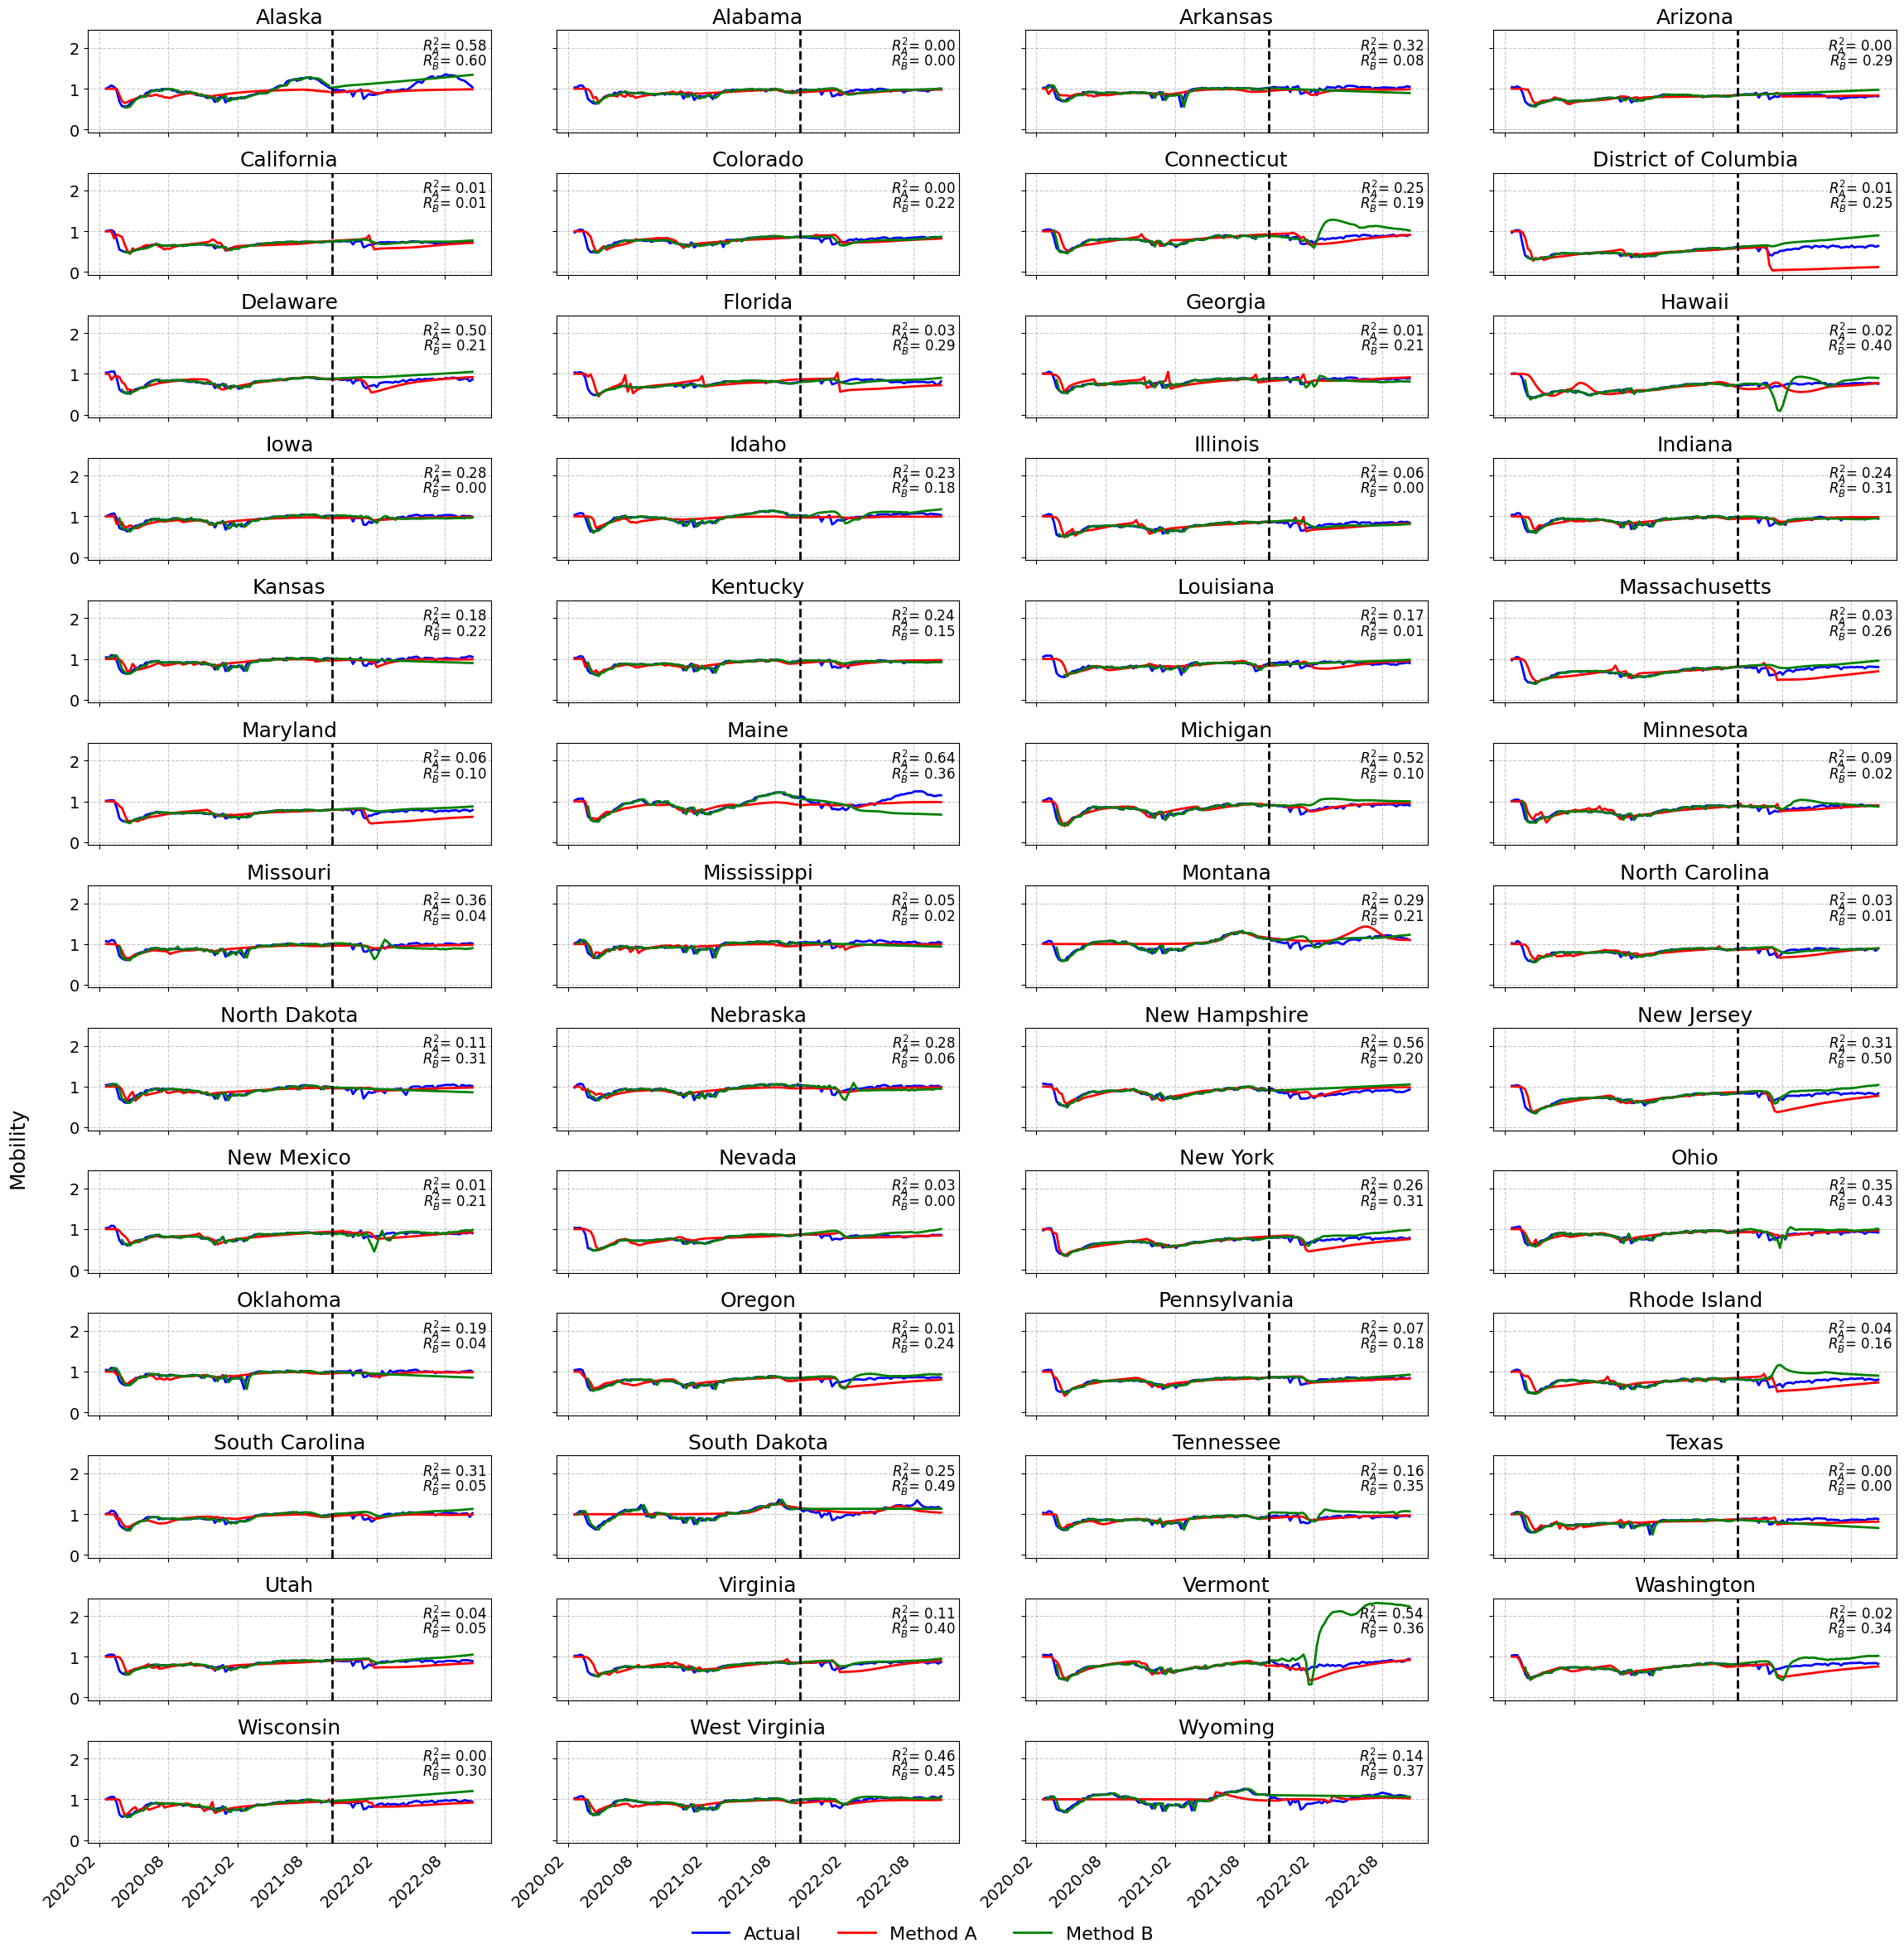

In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# ---------------------------------------------------------------------------
# 1) Increase font sizes globally (can adjust these as needed)
# ---------------------------------------------------------------------------
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 16

# ---------------------------------------------------------------------------
# 2) Prepare a DataFrame to compare test R² for Method A vs. Method B
# ---------------------------------------------------------------------------
comparison_df = pd.DataFrame(
    index=range(51),
    columns=['methodA_r2_test', 'methodB_r2_test']
)

# ---------------------------------------------------------------------------
# 3) Set up the subplot grid: bigger figsize
# ---------------------------------------------------------------------------
n_cols = 4
n_rows = 13
fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 28), sharex=True, sharey=True)
axes = axes.flatten()

# We will collect legend handles/labels just once for a single legend
legend_handles = []
legend_labels = []

# ---------------------------------------------------------------------------
# 4) Example vertical line date
# ---------------------------------------------------------------------------
vertical_line_date = pd.to_datetime('2021-10-06')

# ---------------------------------------------------------------------------
# 5) Loop through each state
# ---------------------------------------------------------------------------
for s in range(51):
    ax = axes[s]

    # ------------------------ Method A Computations ---------------------------
    values = state_dict[s].copy()  # Full data for state s
    d1 = answers_asy_test['best_delay1'][s]
    d2 = answers_asy_test['best_delay2'][s]
    o = int(round(answers_asy_test['best_order'][s]))  # ensure integer
    alpha = answers_asy_test['best_alpha'][s]
    best_k = answers_asy_test['best_k'][s]

    df_A = values.reset_index(drop=True)
    
    # Create shifted columns based on the order 'o' for B_est
    for i in range(o + 1):
        column_name = f"B_est_{i}"
        df_A[column_name] = df_A["case_rate"].astype(float)

    # Apply the asymmetric delay logic
    for i in range(len(df_A["case_rate"]) - 1):
        if df_A.loc[i, 'case_rate'] < df_A.loc[i, f'B_est_{o}']:
            d = d2
        else:
            d = d1
        for j in range(1, o + 1):
            prev_column = f'B_est_{j-1}'
            current_column = f'B_est_{j}'
            df_A.loc[i + 1, current_column] = (
                df_A.loc[i, current_column] +
                (df_A.loc[i, prev_column] - df_A.loc[i, current_column]) / (d / o)
            )

    # Compute Method A's predicted mobility
    denominator = df_A['cumulative_case_rate'].copy()
    denominator[denominator == 0] = 1  # avoid divide-by-zero
    mob_pred_A = np.exp(best_k * df_A[f"B_est_{o}"] / (denominator ** (alpha / 100)))

    # Convert back to time-index
    df_plot_A = values.copy()
    df_plot_A.reset_index(inplace=True)
    df_plot_A['date'] = pd.to_datetime(df_plot_A['date'])
    df_plot_A.set_index('date', inplace=True)

    # Split first 85 rows as training, rest as test
    train_end_index = 85
    actual_mob = df_plot_A['mobility']
    fitted_mob_A = mob_pred_A.iloc[:train_end_index]    # Method A's in-sample
    projected_mob_A = mob_pred_A.iloc[train_end_index:] # Method A's out-of-sample

    # Align indexes for plotting
    fitted_mob_A.index = df_plot_A.index[:train_end_index]
    projected_mob_A.index = df_plot_A.index[train_end_index:]
    
    # ------------------------ Method B (New ARDL/OLS) ------------------------
    model_info = results_dict_ols[s]
    if model_info is None:
        # If there's no model for this state, handle gracefully
        fitted_values_B = pd.Series(dtype=float)
        fitted_index_B = pd.DatetimeIndex([])
        projected_B = pd.Series(dtype=float)
    else:
        # 1) Unpack the model and lags
        ols_model_B = model_info['model']
        p = model_info['p']
        q = model_info['q']
        
        # 2) Rebuild the training data to align with the model's fittedvalues
        df_train_B = train_dict[s].copy()
        df_train_B.sort_index(inplace=True)
        
        # Create p lags of mobility
        for i in range(1, p + 1):
            df_train_B[f'mobility_t-{i}'] = df_train_B['mobility'].shift(i)
        # Create q lags of case_rate
        for j in range(1, q + 1):
            df_train_B[f'case_rate_t-{j}'] = df_train_B['case_rate'].shift(j)
        
        df_train_B.dropna(inplace=True)
        
        # In-sample fitted values
        fitted_values_B = ols_model_B.fittedvalues
        fitted_index_B = df_train_B.index
        # Out-of-sample forecast
        projected_B = predictions_dict[s]
    
    # For test R², we need the test_data
    test_data_B = test_dict[s].copy()
    test_data_B.sort_index(inplace=True)
    projected_B = projected_B.reindex(test_data_B.index, fill_value=np.nan)

    # ----------------------- Plot on the Same Axes ---------------------------
    # 1) Actual mobility
    line_actual, = ax.plot(
        values.index,
        values['mobility'],
        label='Actual',
        color='blue',
        linewidth=2
    )

    # 2) Method A (fitted + projected)
    line_A_fitted, = ax.plot(
        fitted_mob_A.index, fitted_mob_A,
        label='Method A',
        color='red',
        linewidth=2
    )
    line_A_proj, = ax.plot(
        projected_mob_A.index, projected_mob_A,
        label='_nolegend_',
        color='red',
        linewidth=2
    )

    # 3) Method B (fitted + projected)
    line_B_fitted, = ax.plot(
        fitted_index_B, fitted_values_B,
        label='Method B',
        color='green',
        linewidth=2
    )
    line_B_proj, = ax.plot(
        projected_B.index, projected_B,
        label='_nolegend_',
        color='green',
        linewidth=2
    )

    # Vertical line
    ax.axvline(x=vertical_line_date, color='black', linestyle='--', linewidth=2)

    # ---------------------- Compute R² (Test) ----------------------
    # Method A R²
    mob_actual_test_A = df_plot_A['mobility'].iloc[train_end_index:]
    mob_actual_test_A = mob_actual_test_A.reindex(projected_mob_A.index)
    if len(mob_actual_test_A) > 1:
        corr_matrix_A = np.corrcoef(projected_mob_A, mob_actual_test_A)
        r2_A = corr_matrix_A[0, 1] ** 2
    else:
        r2_A = np.nan

    # Method B R²
    y_test_actual_B = test_data_B['mobility'].copy()
    y_test_pred_B = projected_B.copy()
    y_test_pred_B = y_test_pred_B.reindex(y_test_actual_B.index)
    if len(y_test_actual_B) > 1:
        corr_matrix_B = np.corrcoef(y_test_pred_B, y_test_actual_B)
        r2_B = corr_matrix_B[0, 1] ** 2
    else:
        r2_B = np.nan

    # Store these in comparison_df
    comparison_df.loc[s, 'methodA_r2_test'] = r2_A
    comparison_df.loc[s, 'methodB_r2_test'] = r2_B

    # Show them in the subplot
    ax.text(
        0.99, 0.95,
        f'$R^2_{{A}}$= {r2_A:.2f}',
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        horizontalalignment='right'
    )
    ax.text(
        0.99, 0.80,
        f'$R^2_{{B}}$= {r2_B:.2f}',
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        horizontalalignment='right'
    )

    # Subplot title
    if 'state_full_name' in values.columns:
        state_name = values["state_full_name"].iloc[0]
    else:
        state_name = f"State {s}"
    ax.set_title(f'{state_name}')

    # Date formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

    ax.grid(True, linestyle='--', alpha=0.7)

    # Collect legend handles/labels only on the first subplot
    if s == 0:
        legend_handles.extend([line_actual, line_A_fitted, line_B_fitted])
        legend_labels.extend(['Actual', 'Method A', 'Method B'])

# Hide any remaining unused subplots
for s in range(51, len(axes)):
    fig.delaxes(axes[s])

# Common y-axis label
fig.text(0.04, 0.5, 'Mobility', va='center', rotation='vertical', fontsize=18)

# ---------------------------------------------------------------------------
# Place the legend higher using loc='lower center' and bbox_to_anchor
# Adjust these parameters as needed
# ---------------------------------------------------------------------------
fig.legend(
    handles=legend_handles,
    labels=legend_labels,
    loc='lower center',           # anchor from the lower-center side of the legend
    bbox_to_anchor=(0.5, 0.15),   # (x=0.5 means horizontally centered, y=0.15 sets height)
    frameon=False,
    ncol=3
)

plt.tight_layout()
# Adjust the margins to allow room for the legend
plt.subplots_adjust(bottom=0.2, left=0.08)
plt.show()


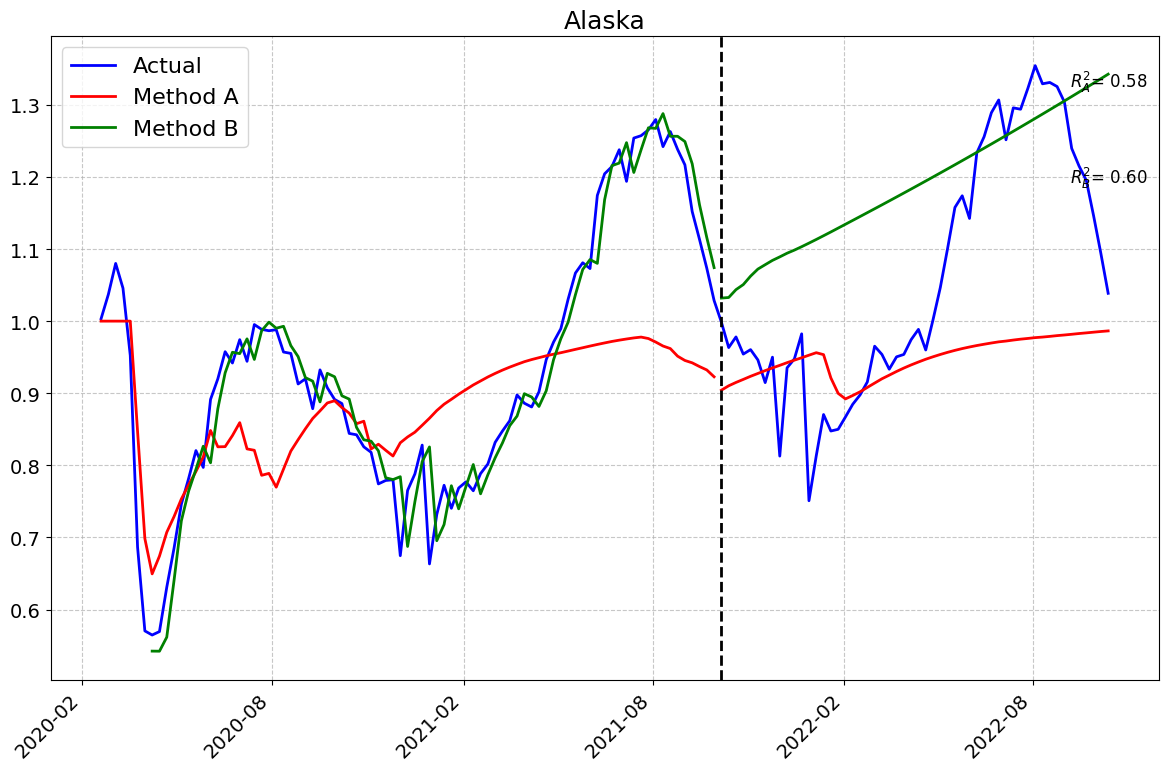

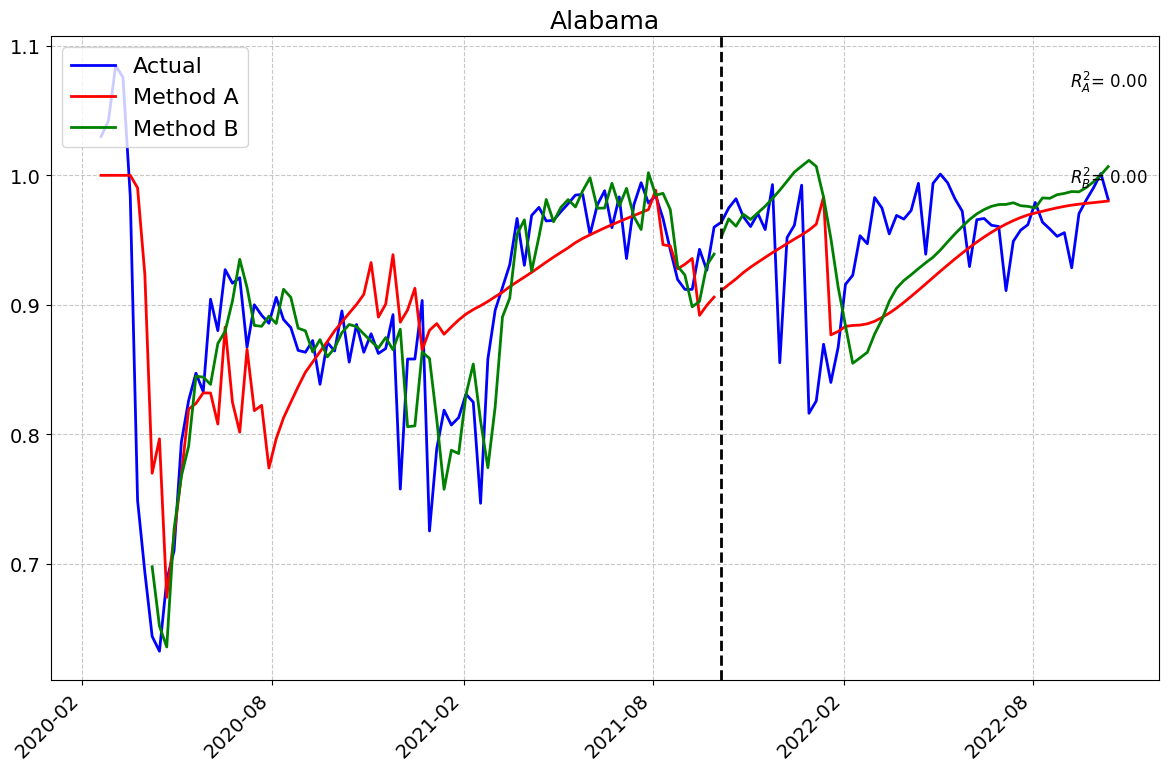

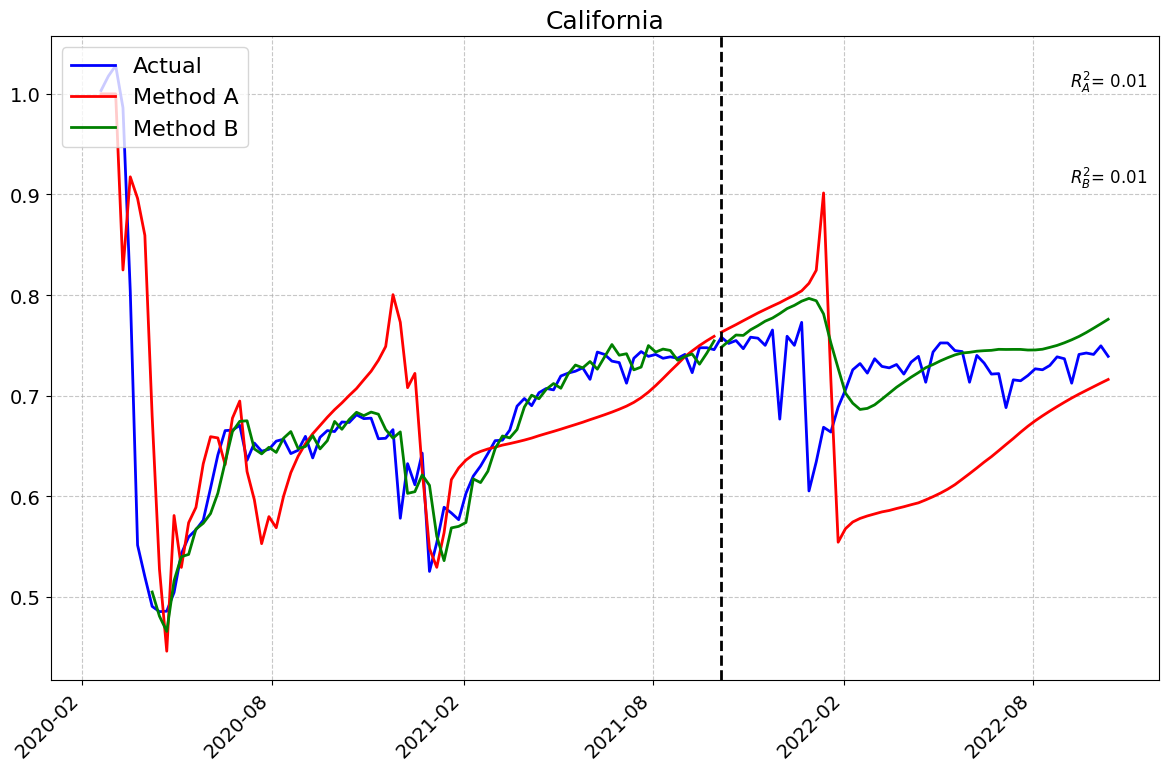

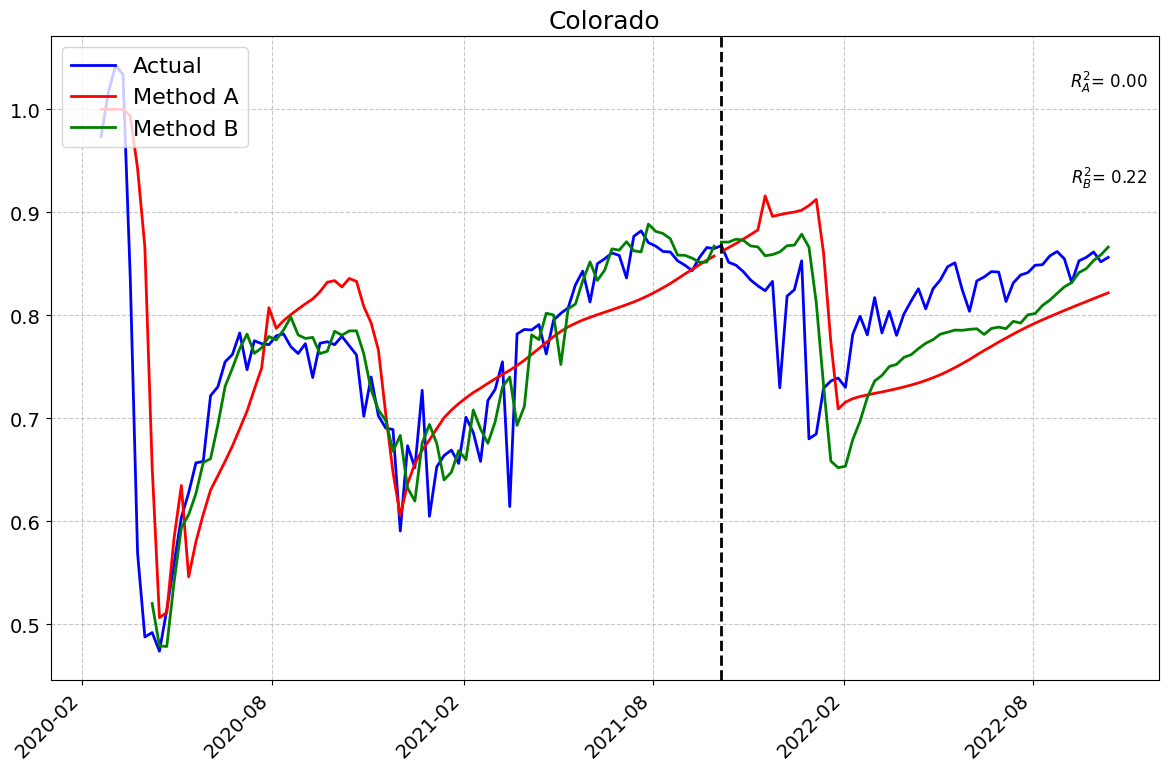

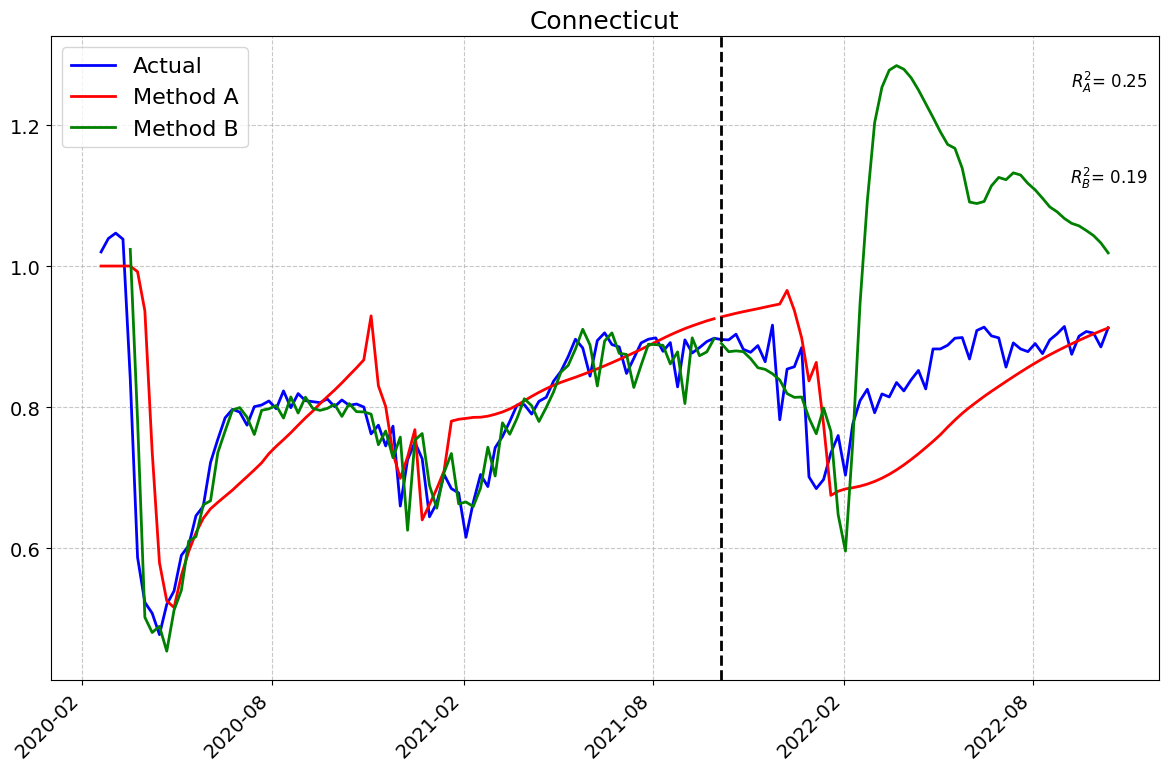

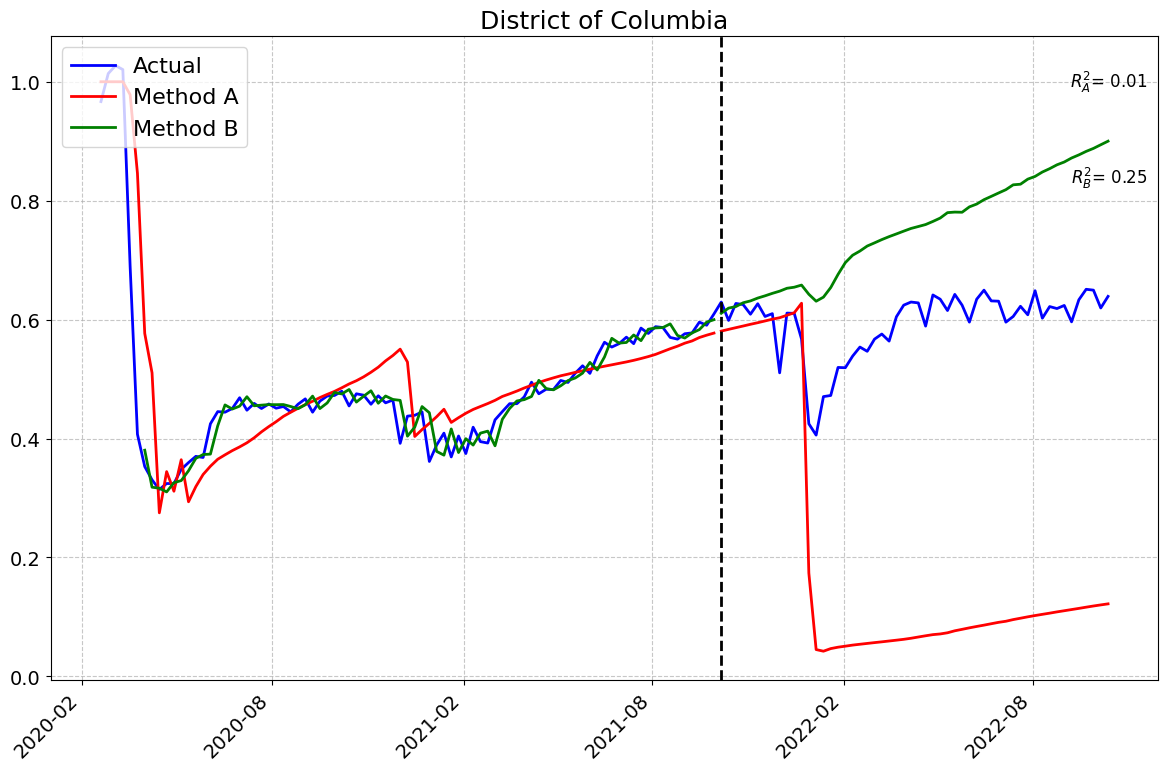

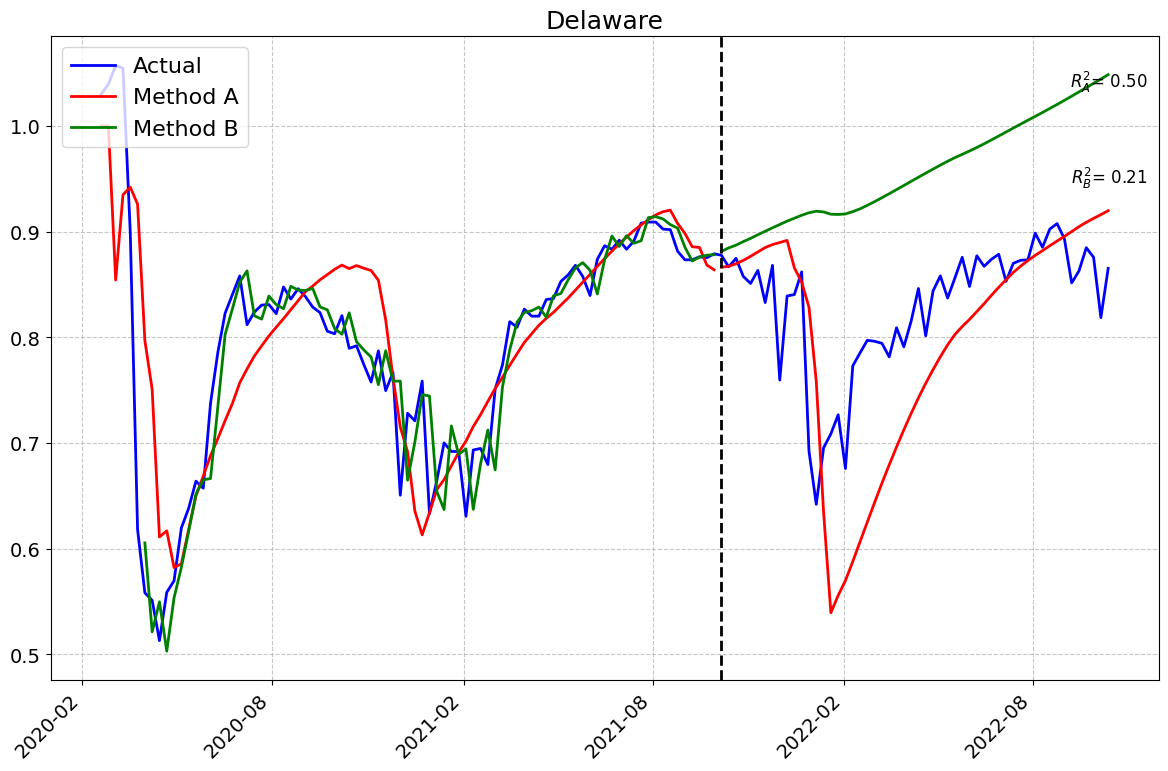

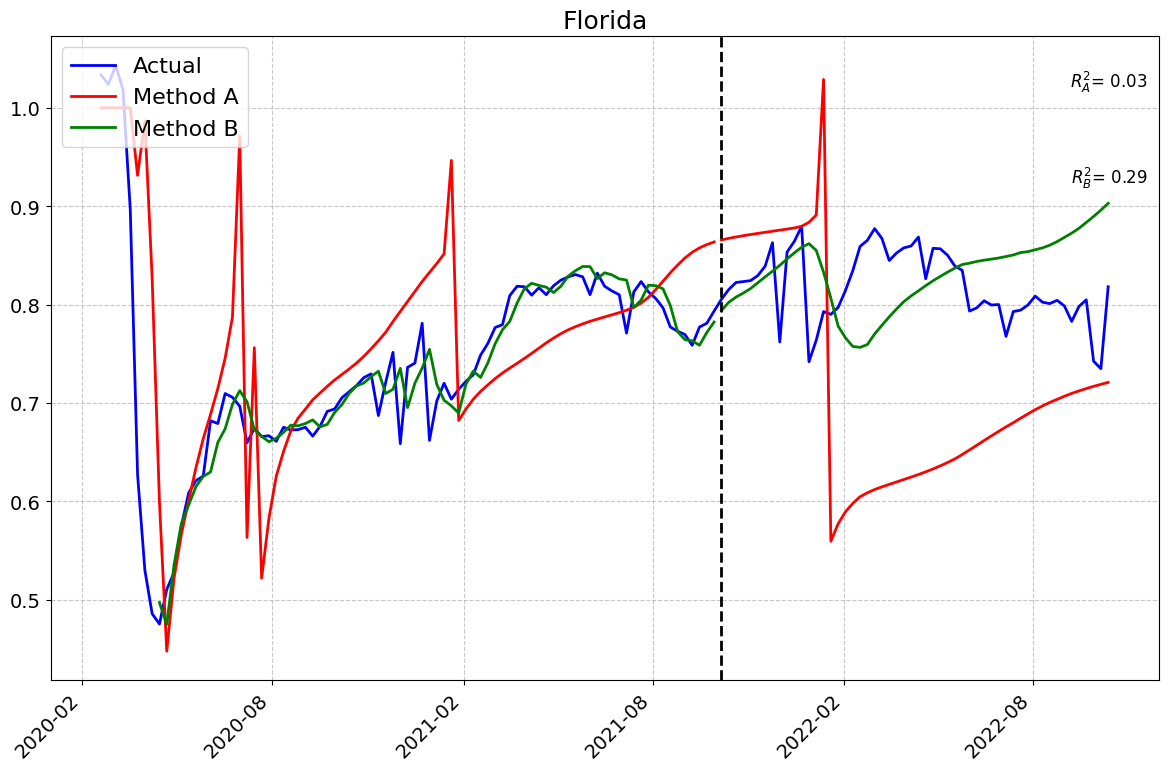

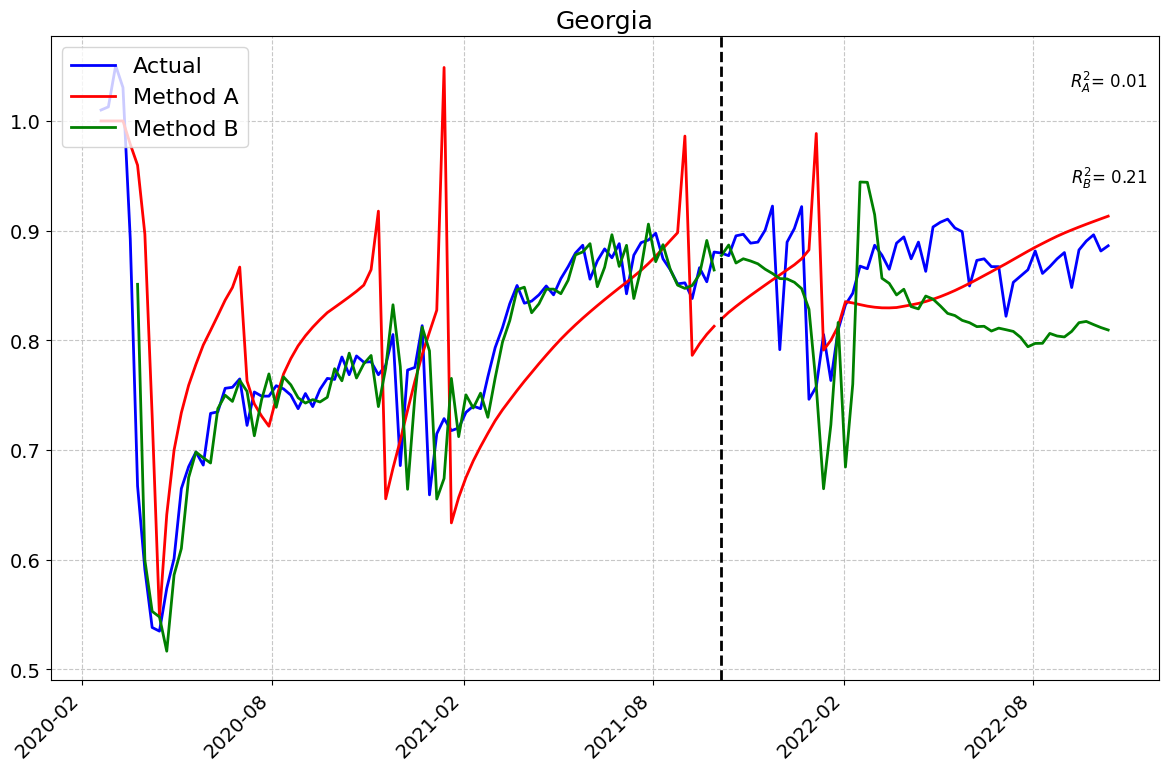

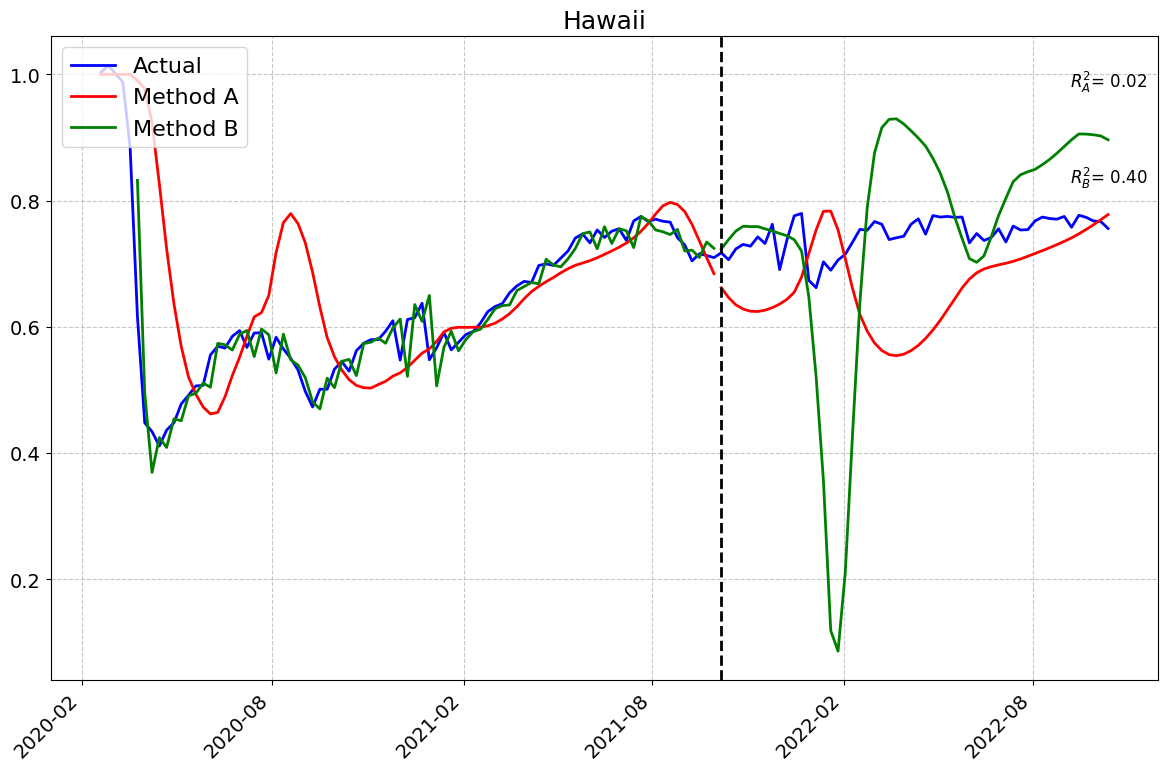

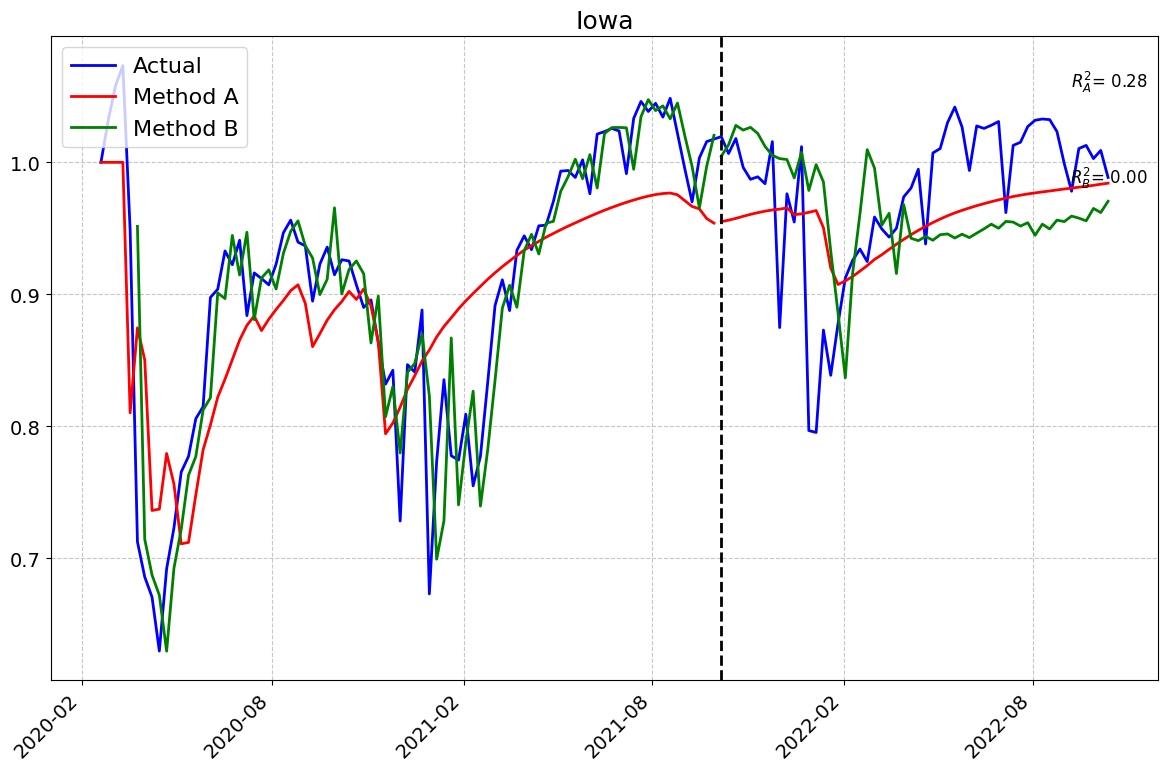

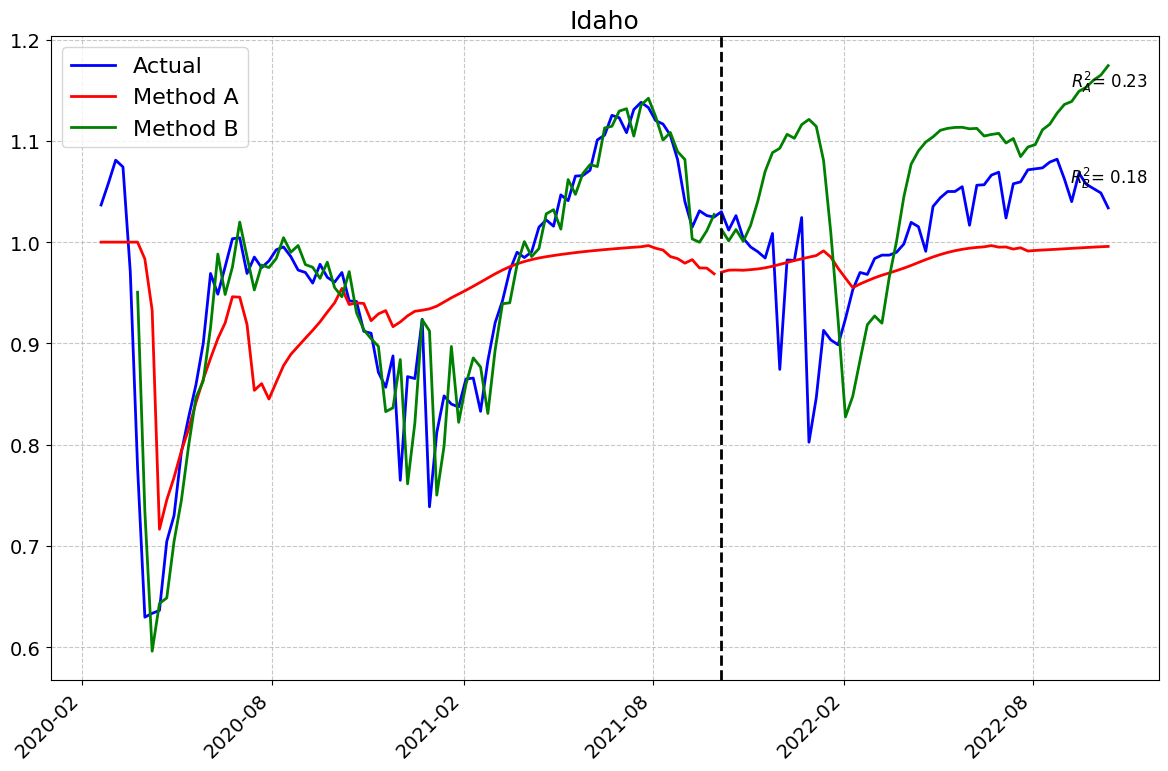

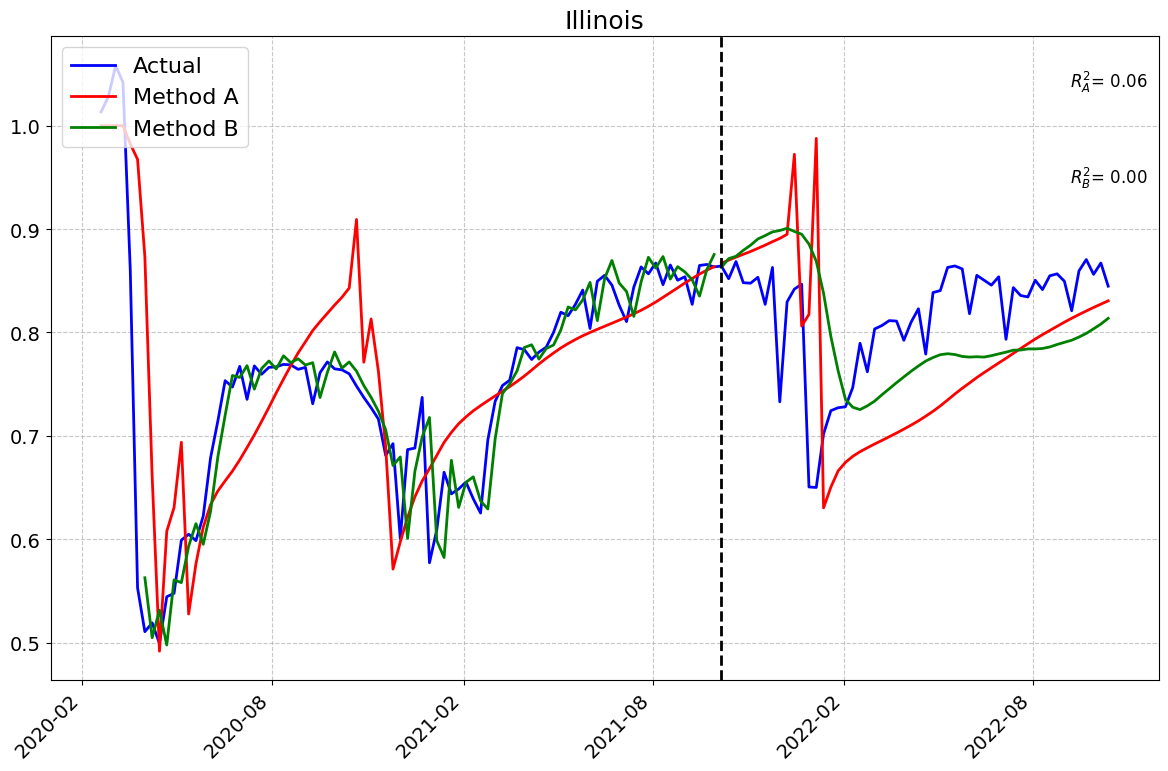

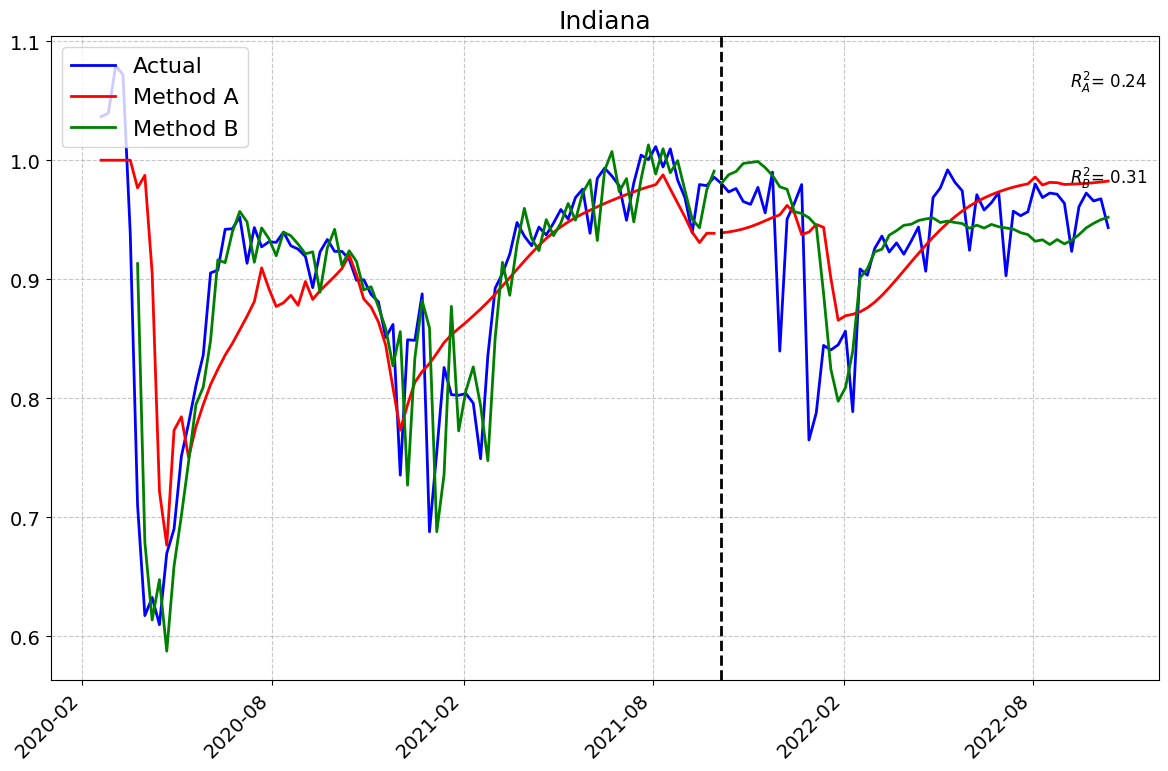

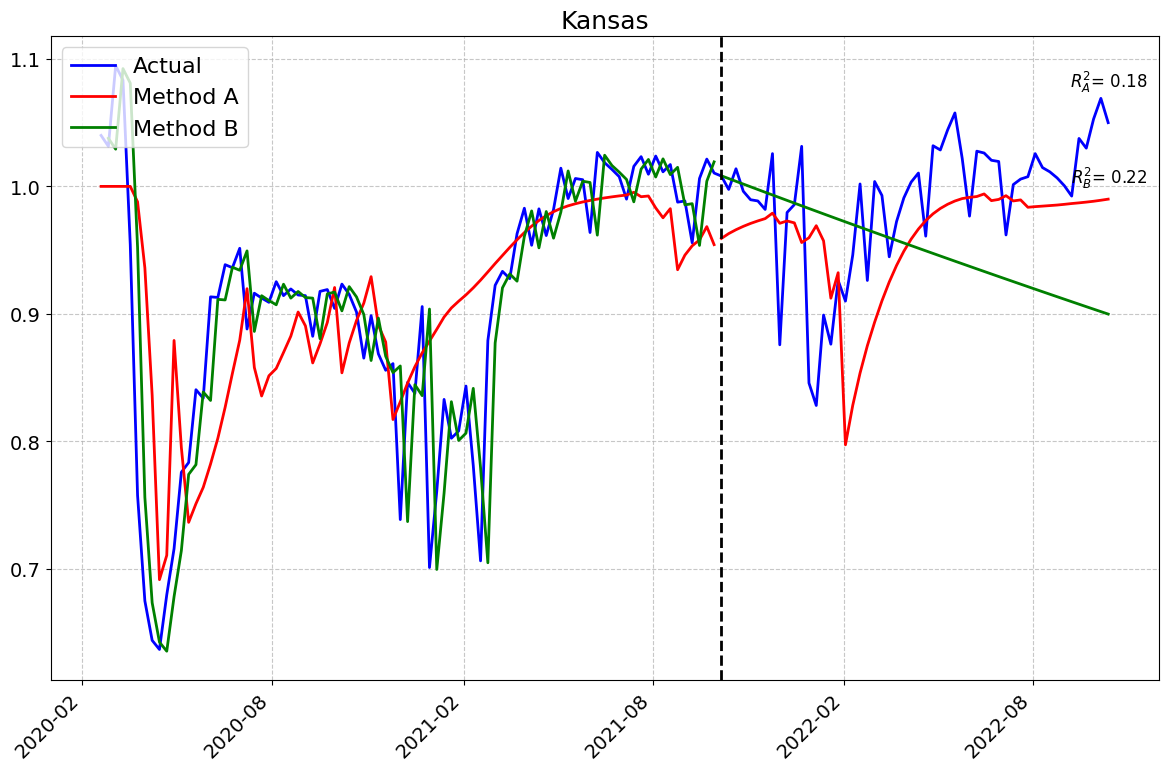

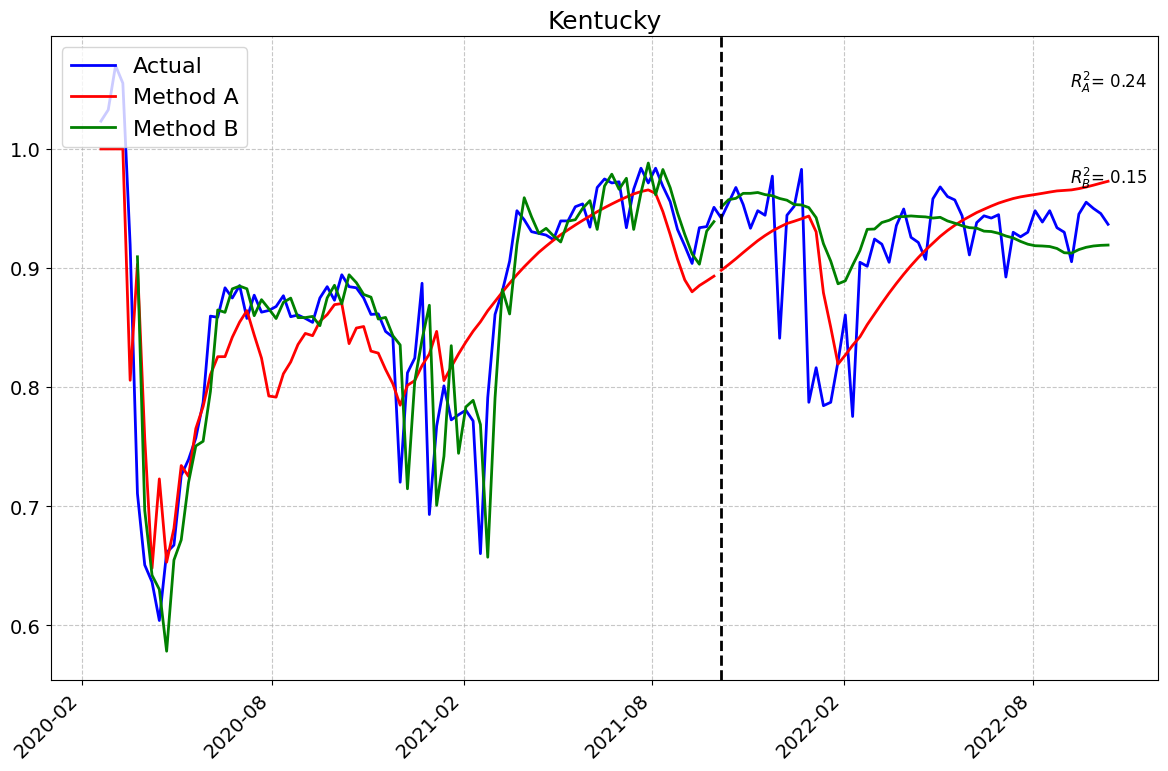

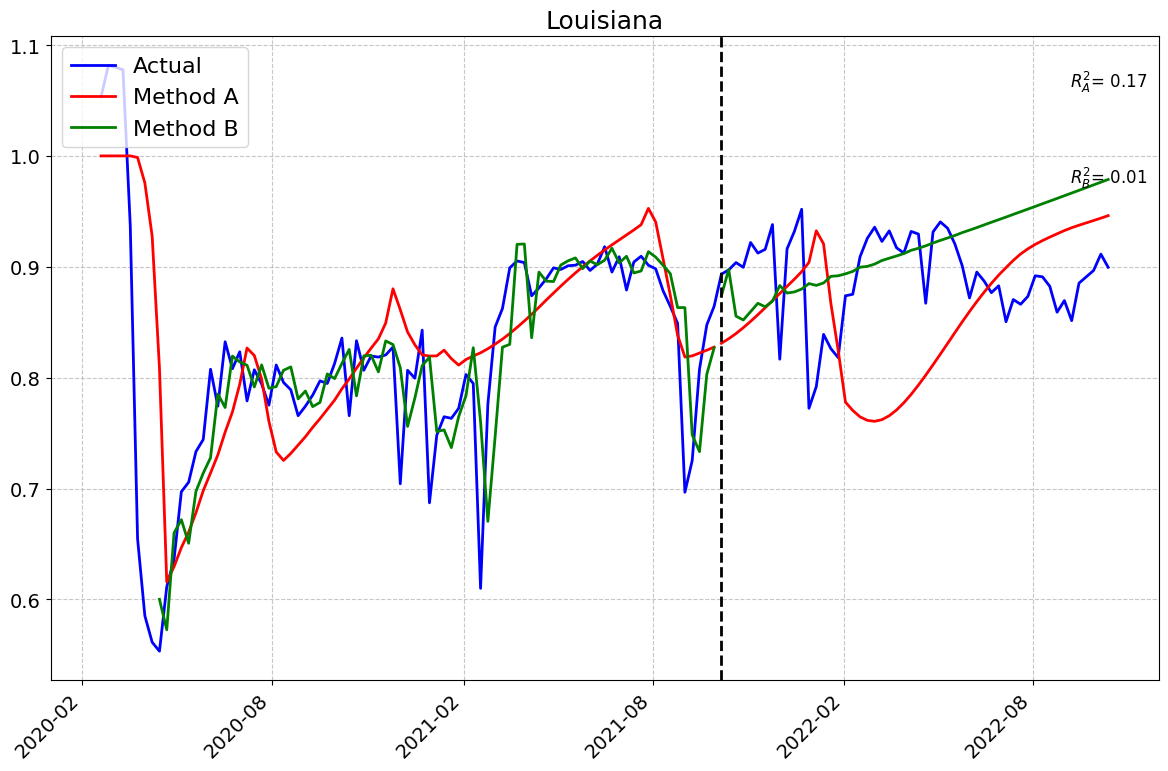

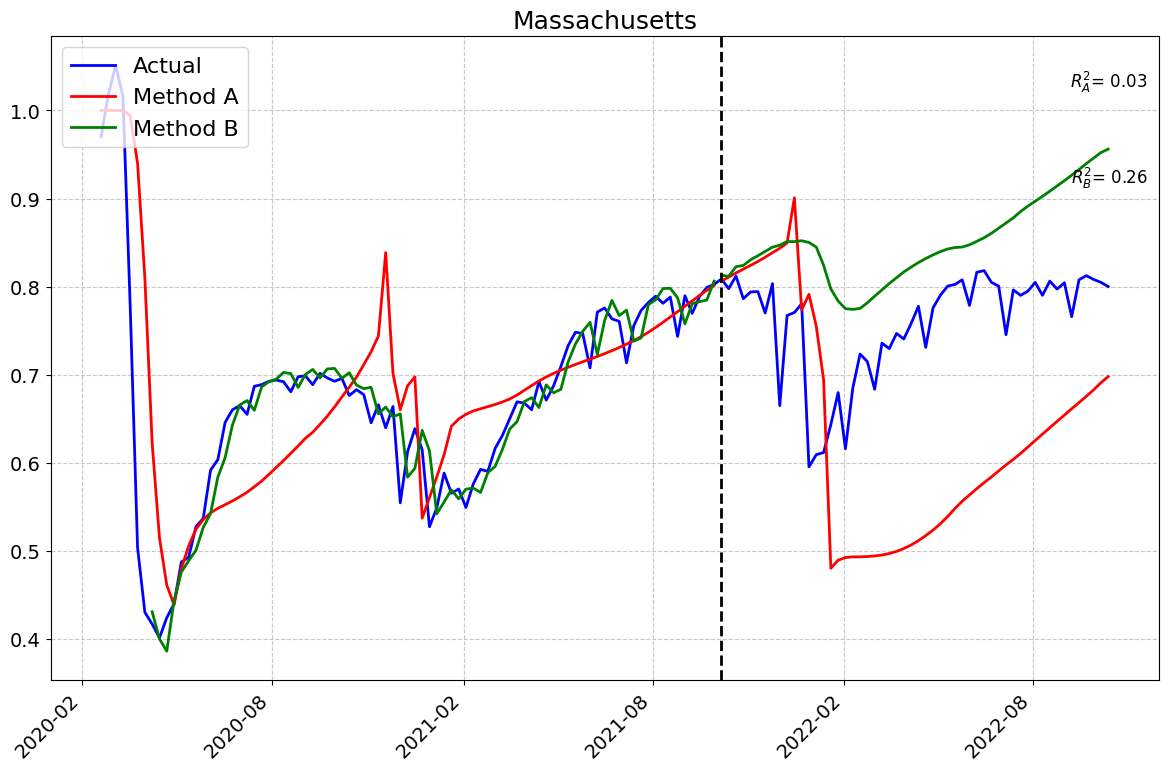

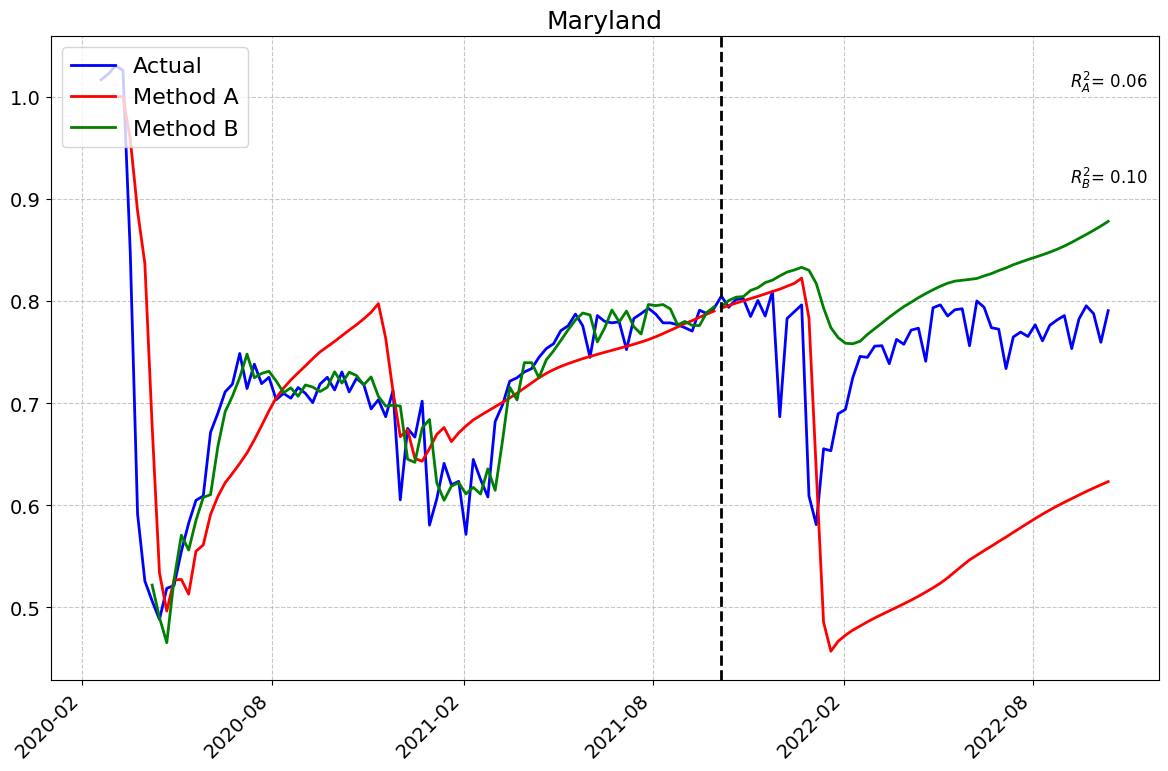

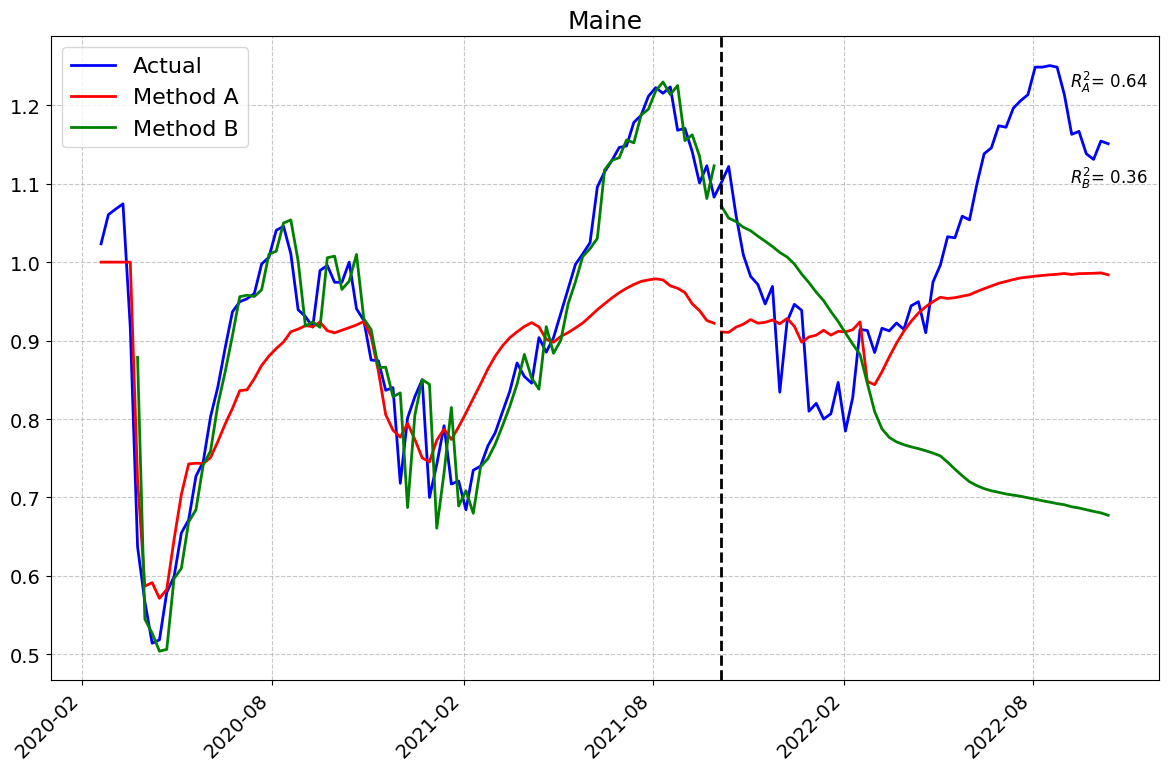

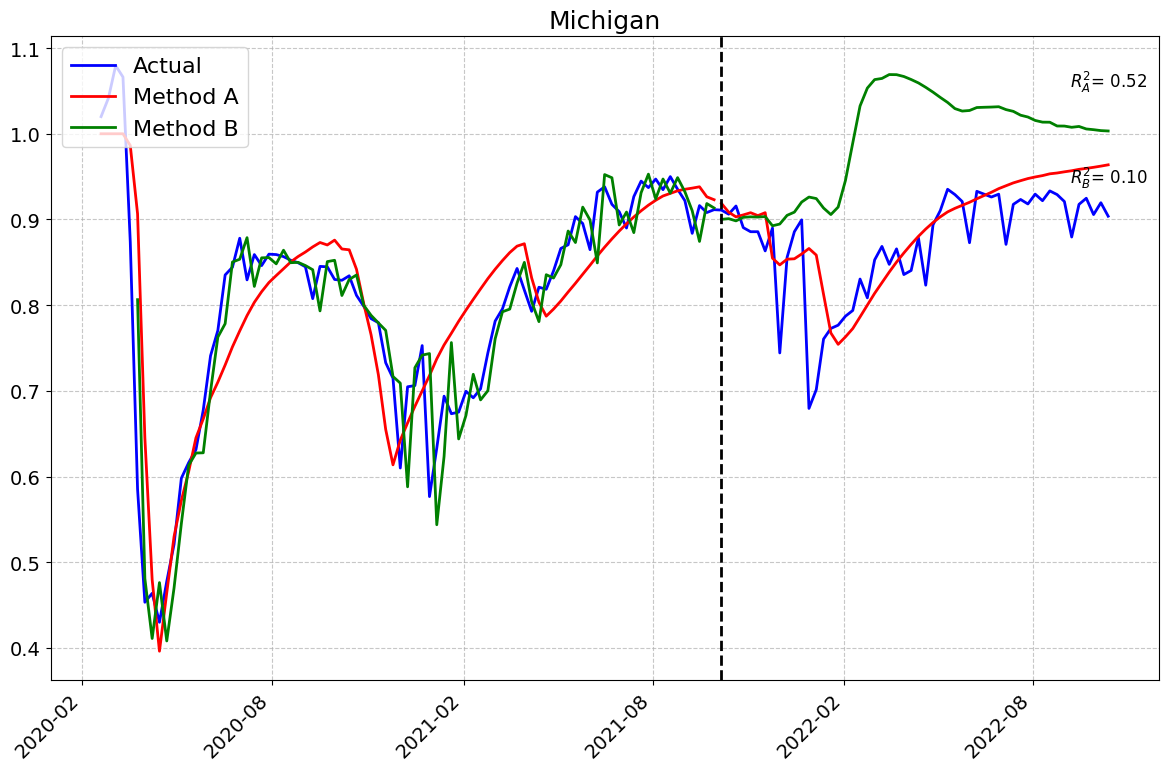

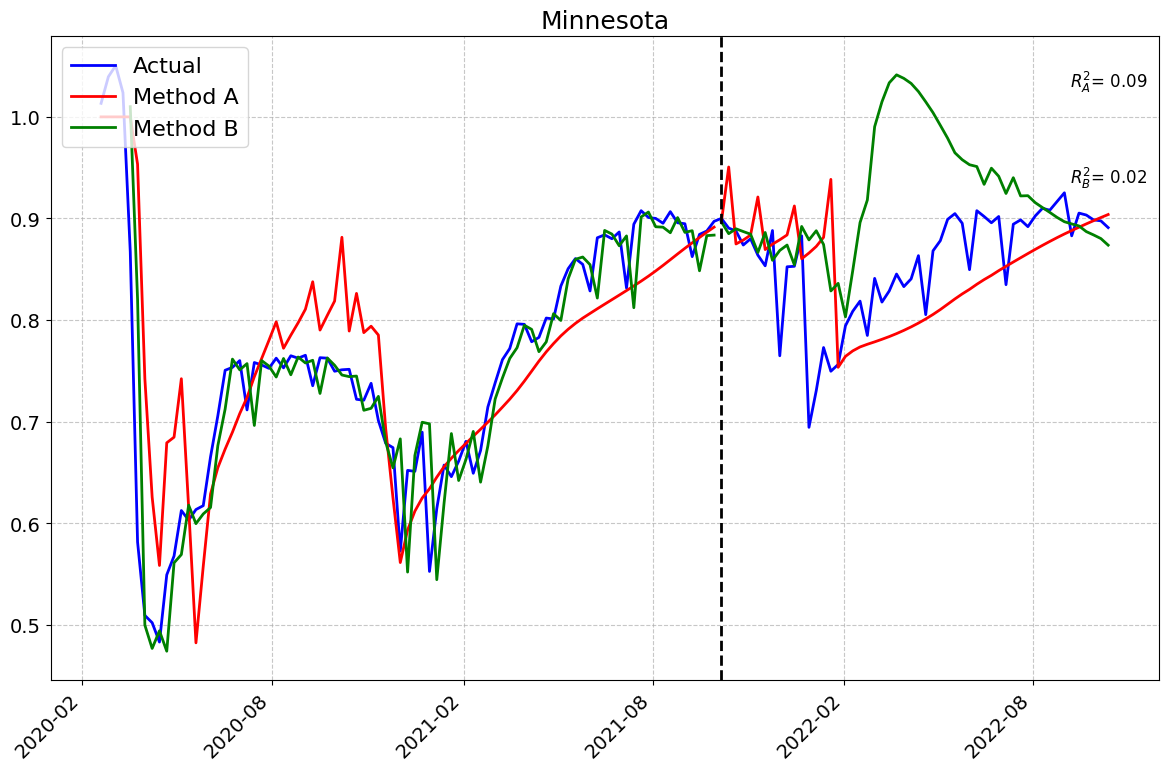

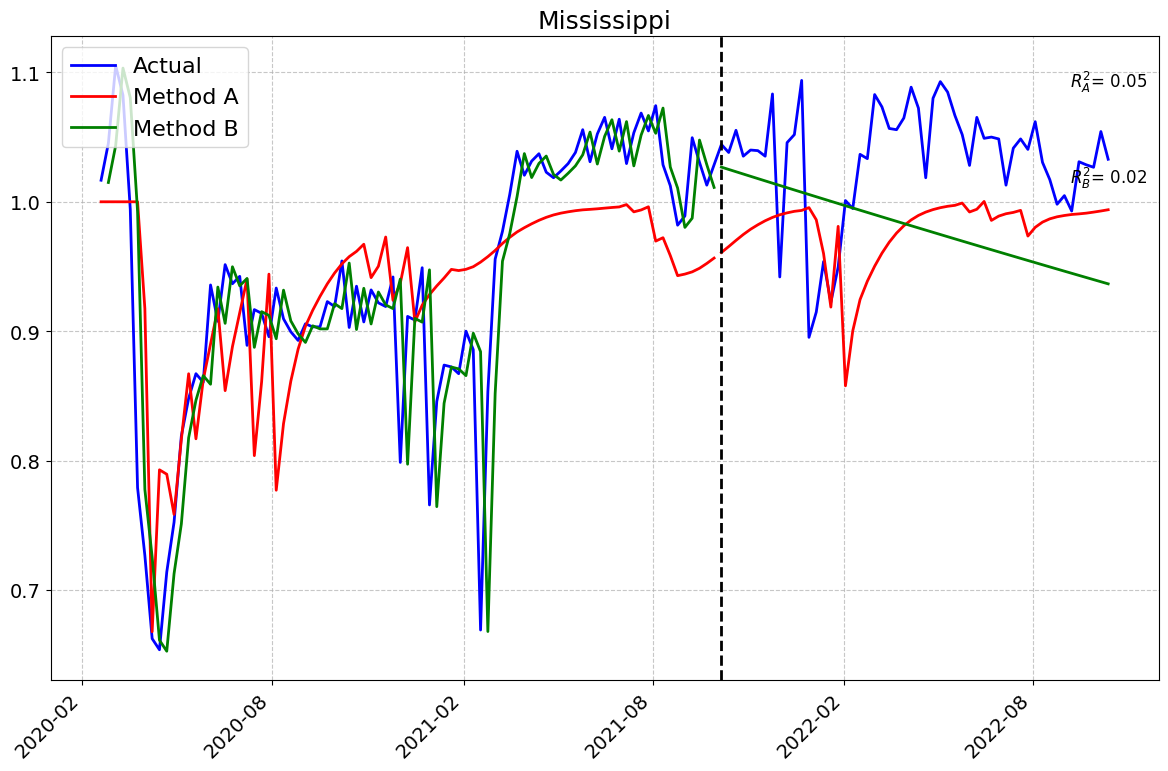

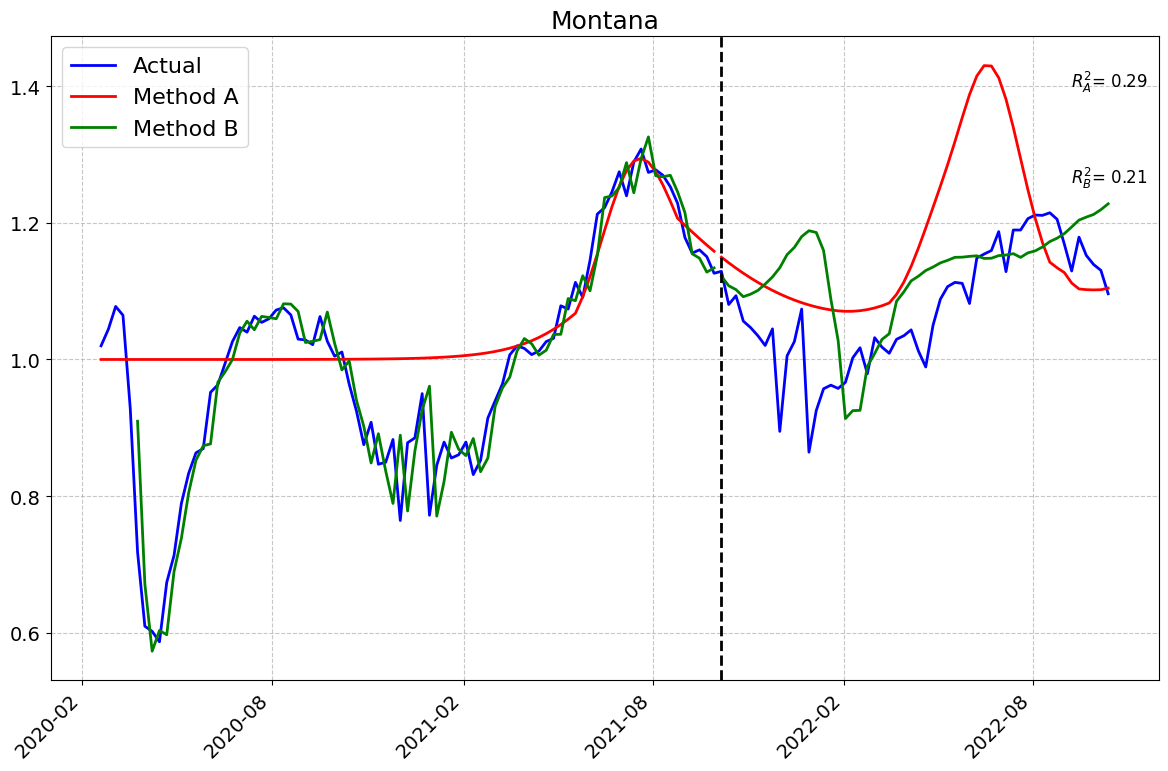

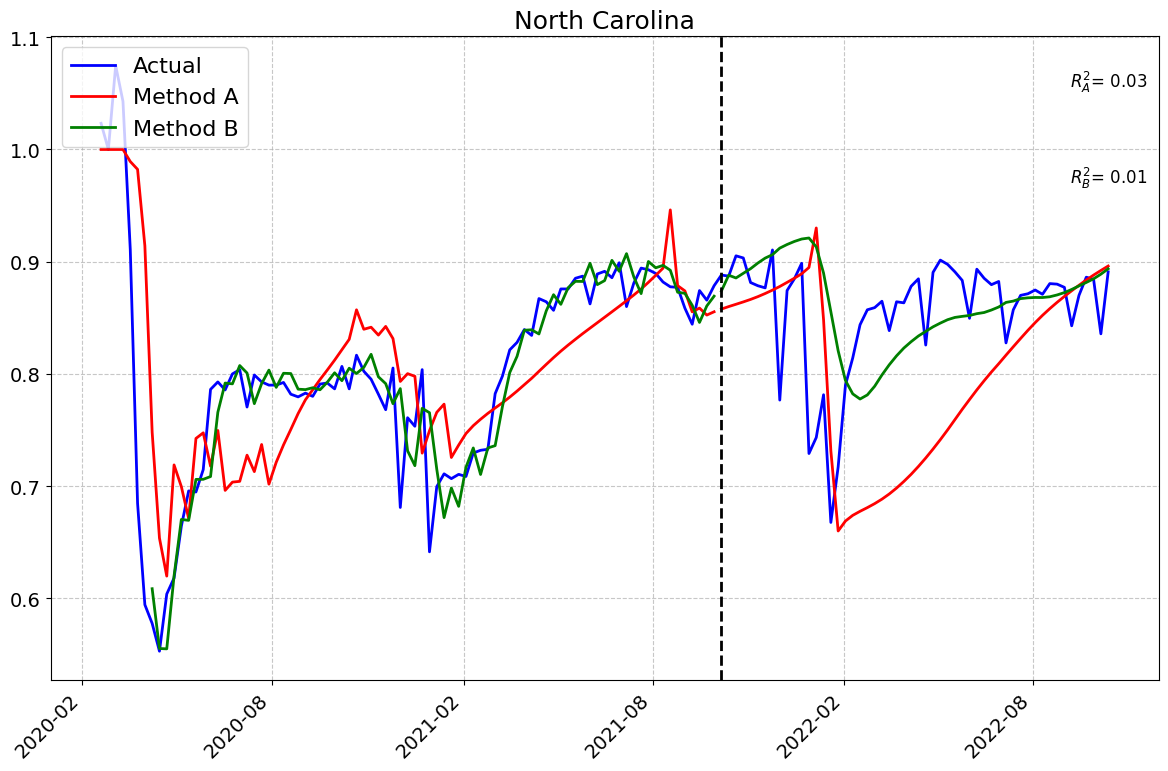

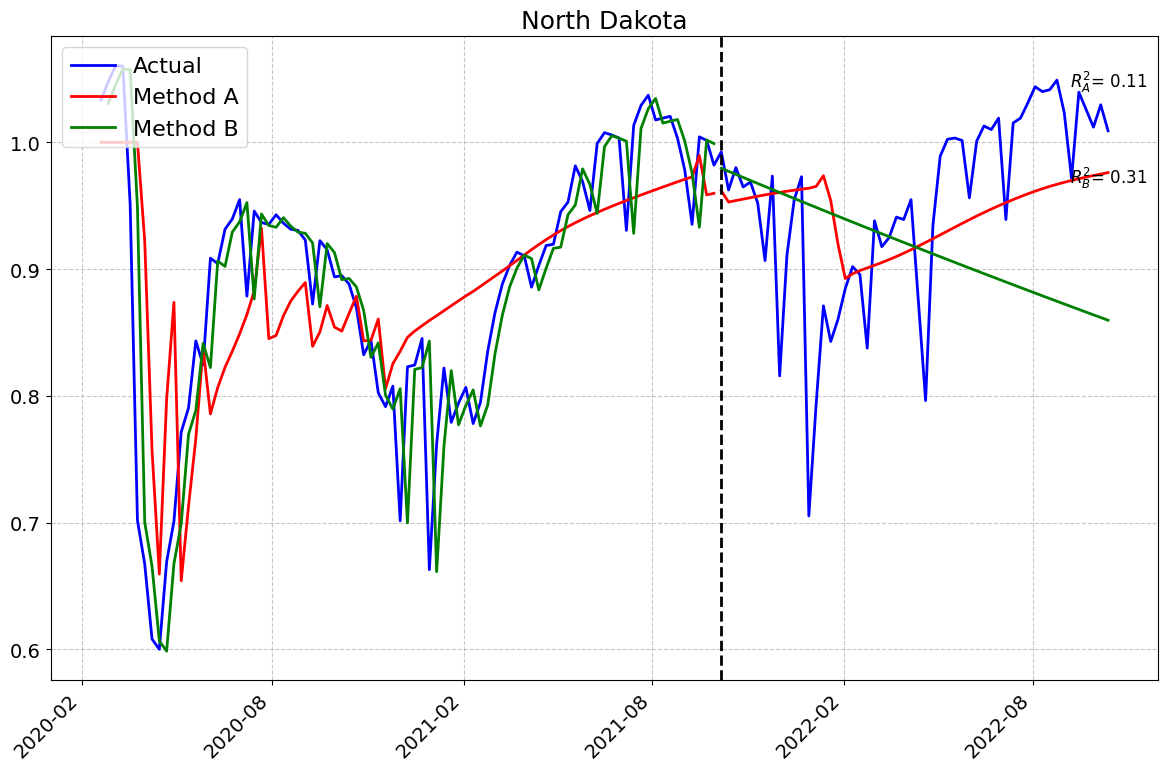

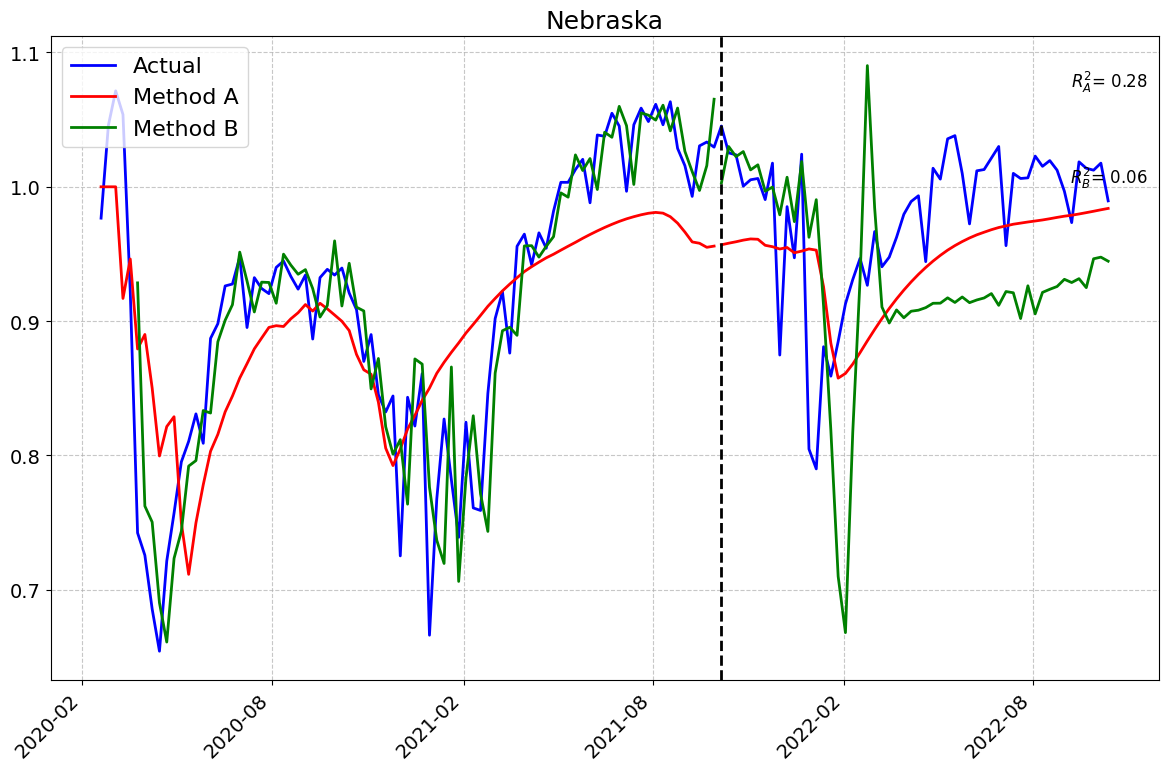

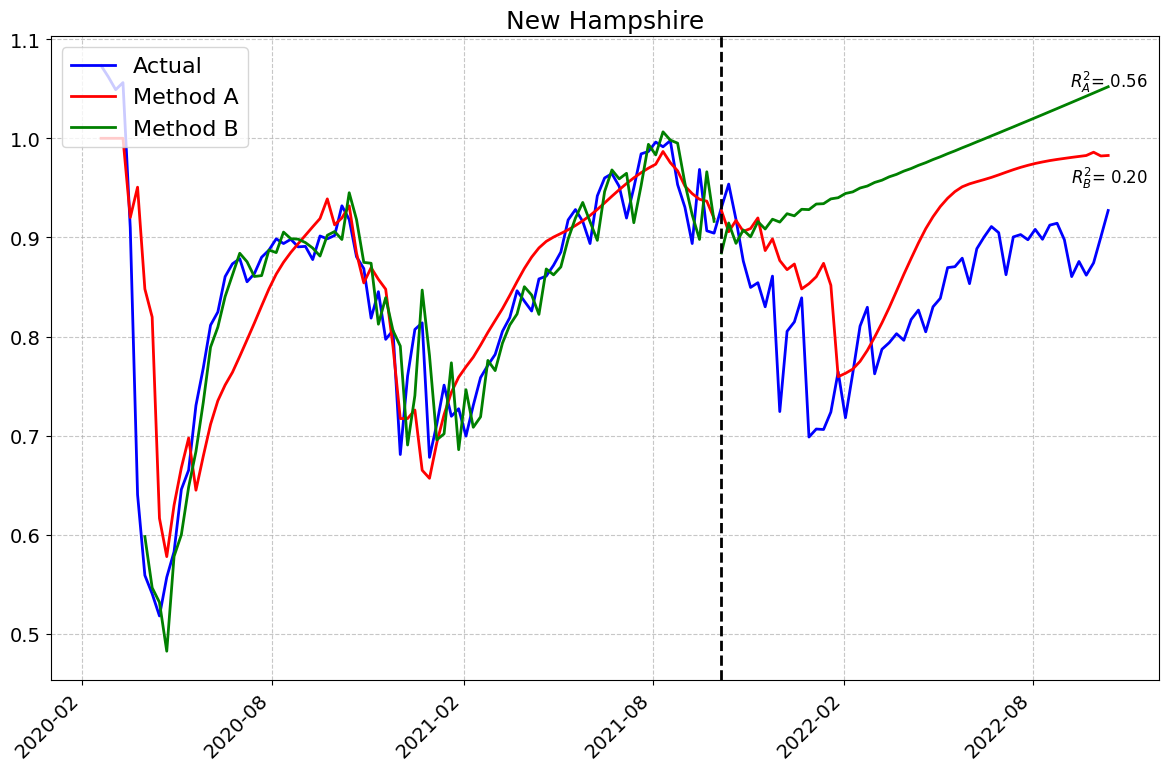

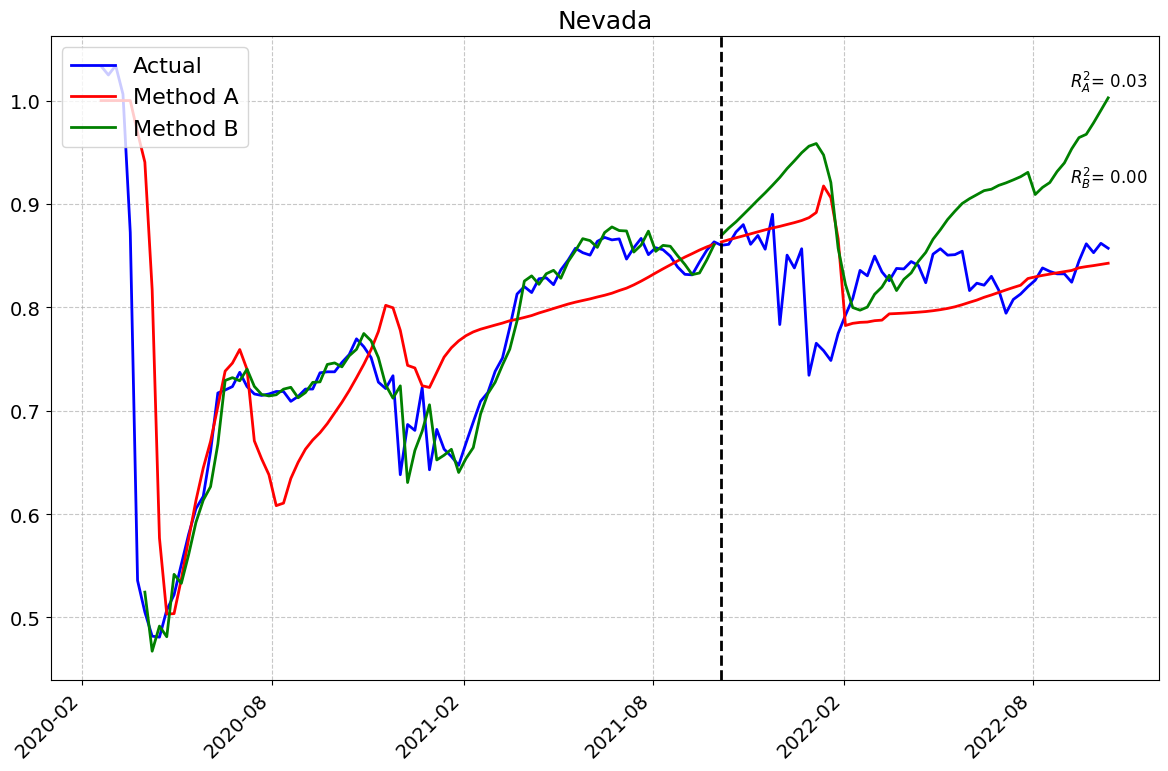

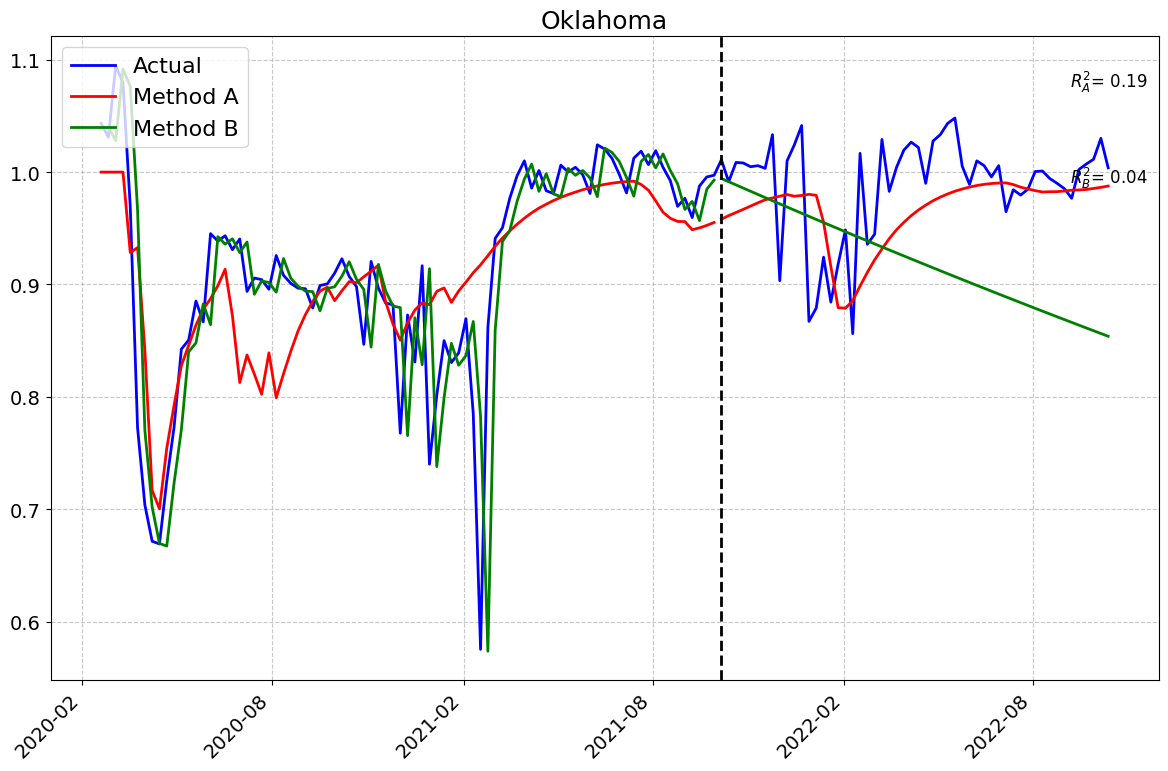

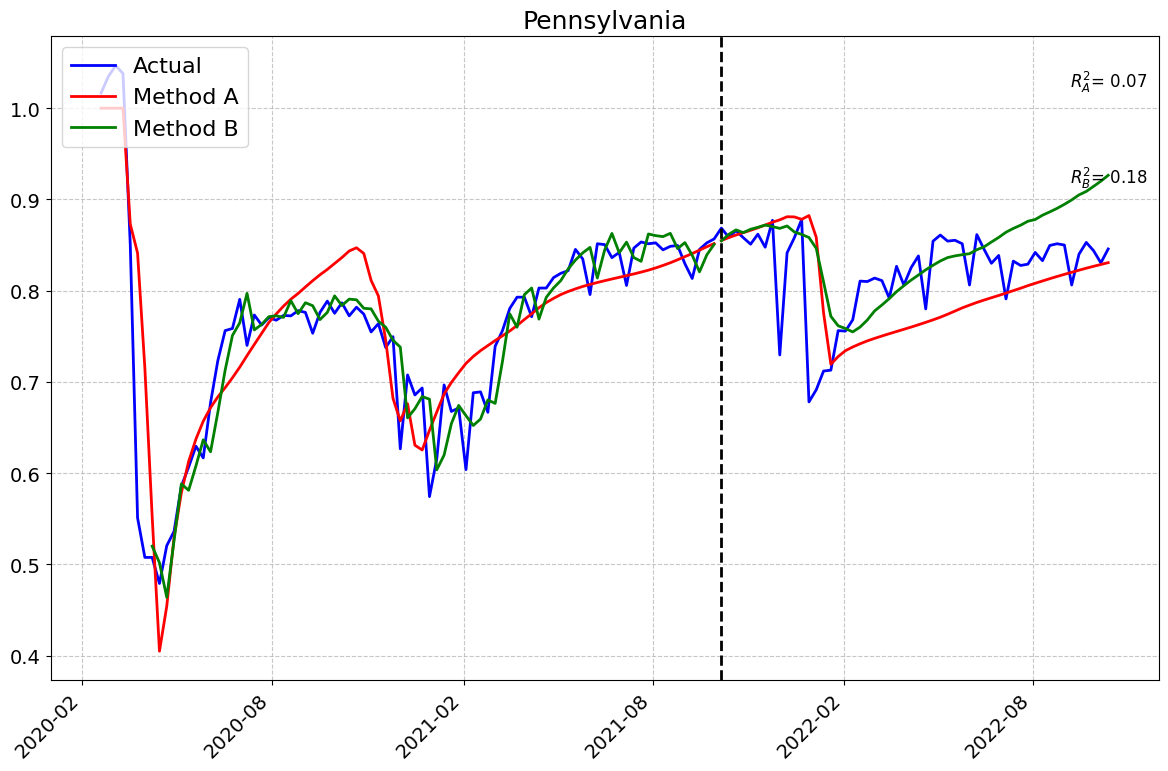

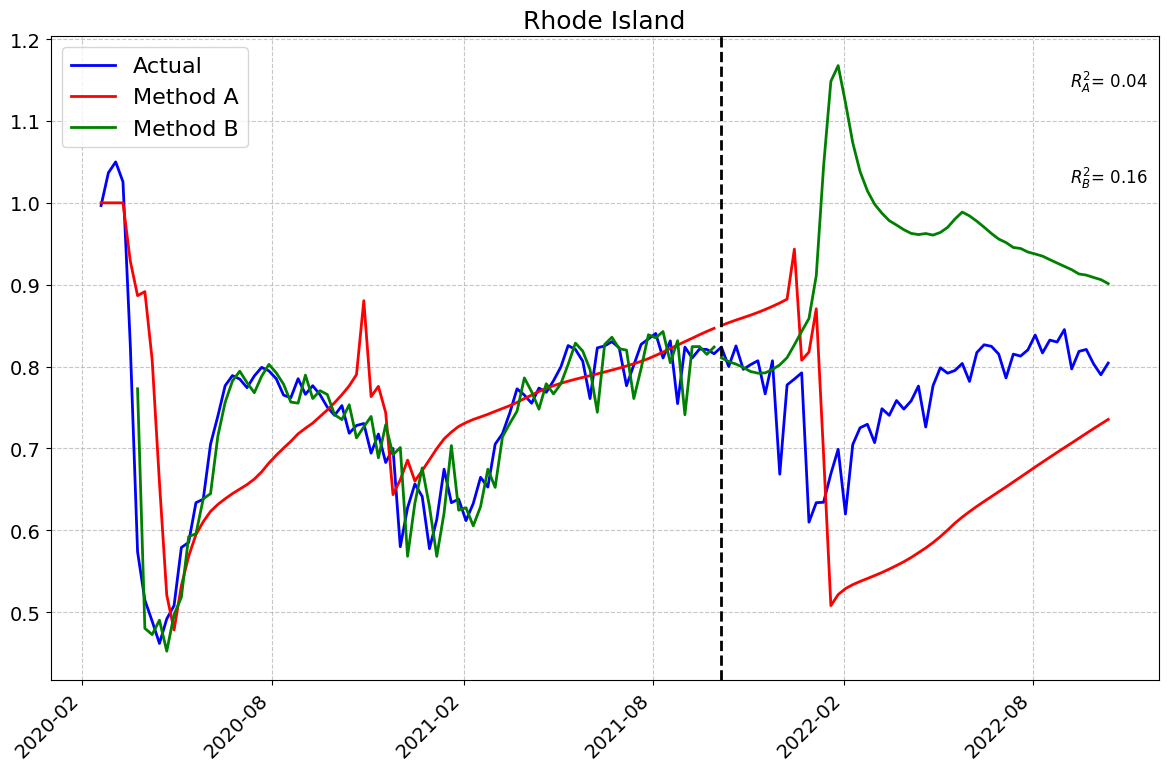

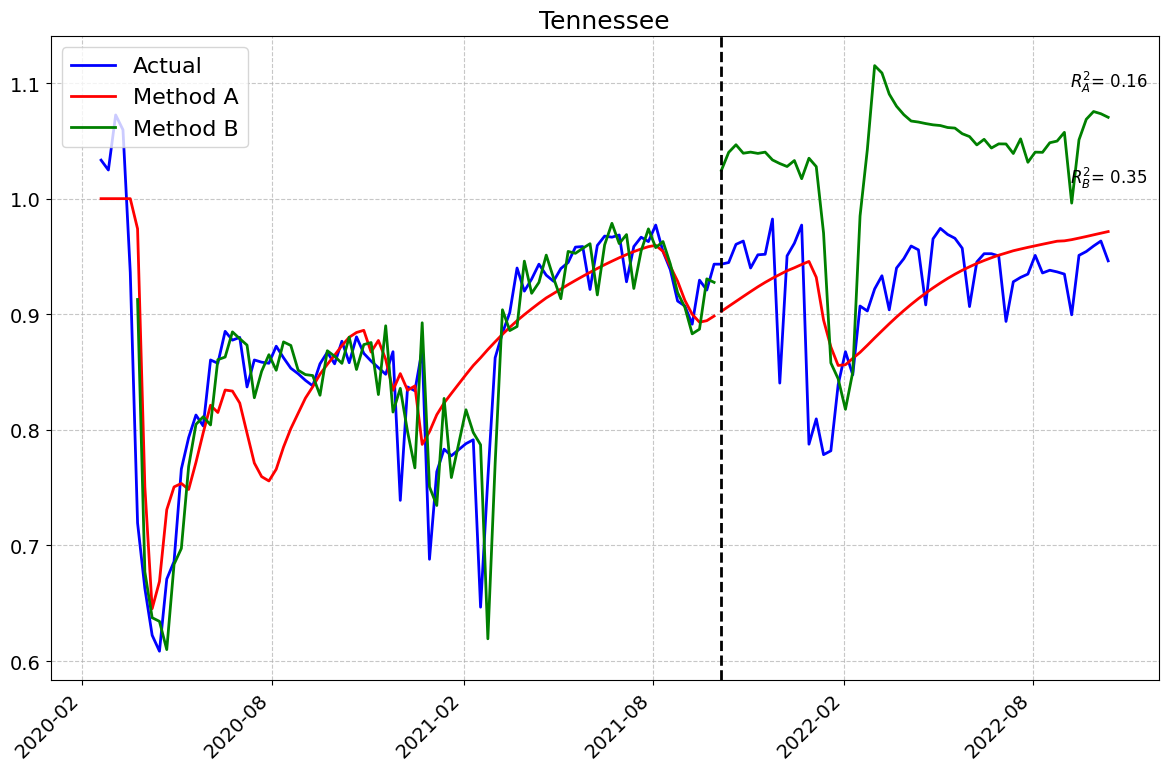

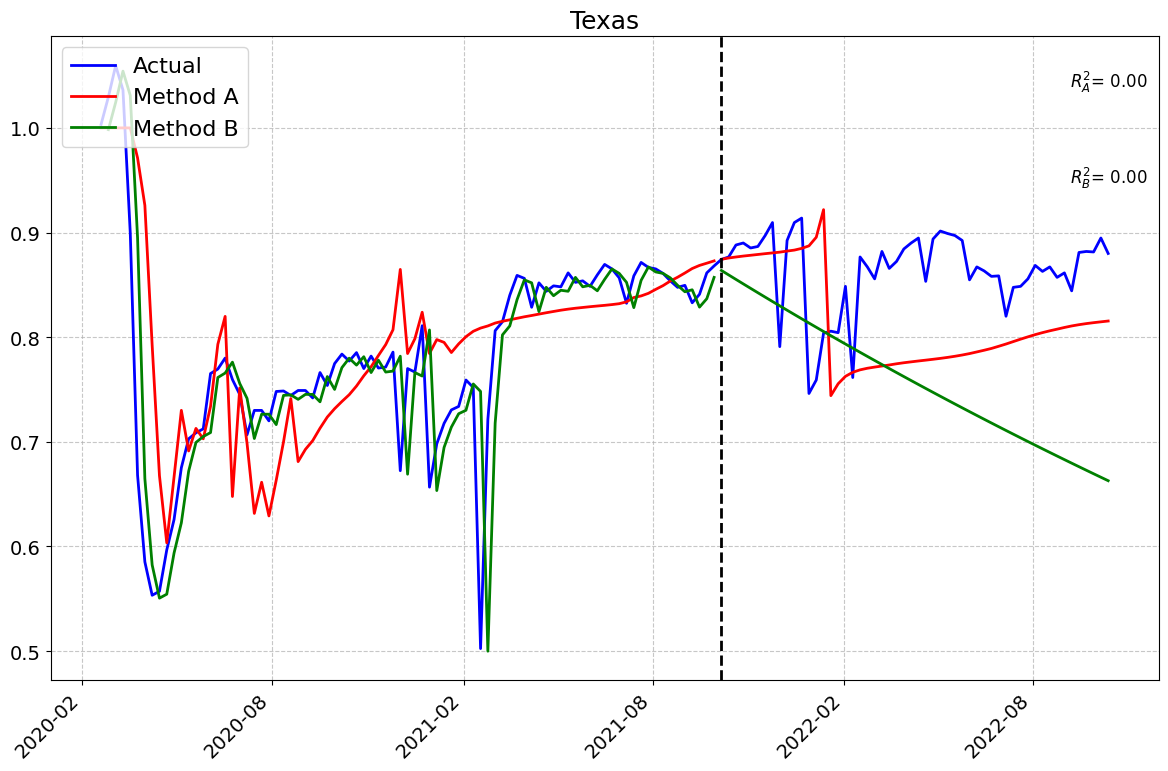

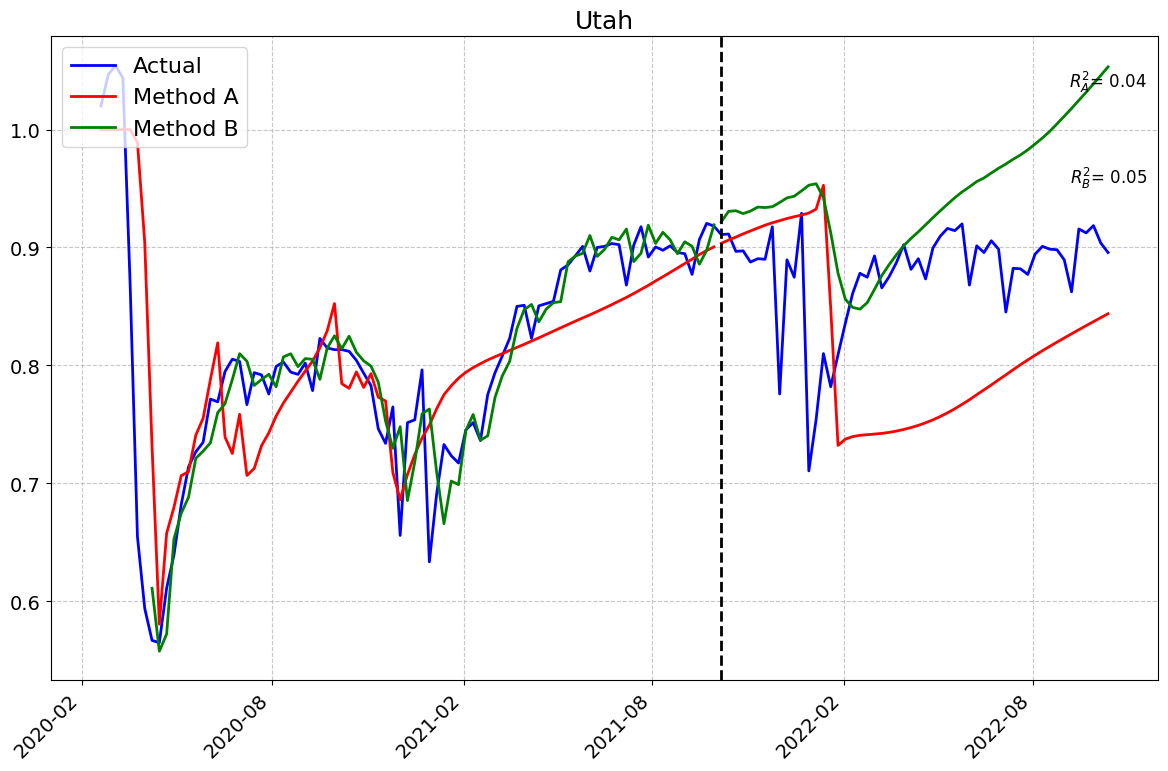

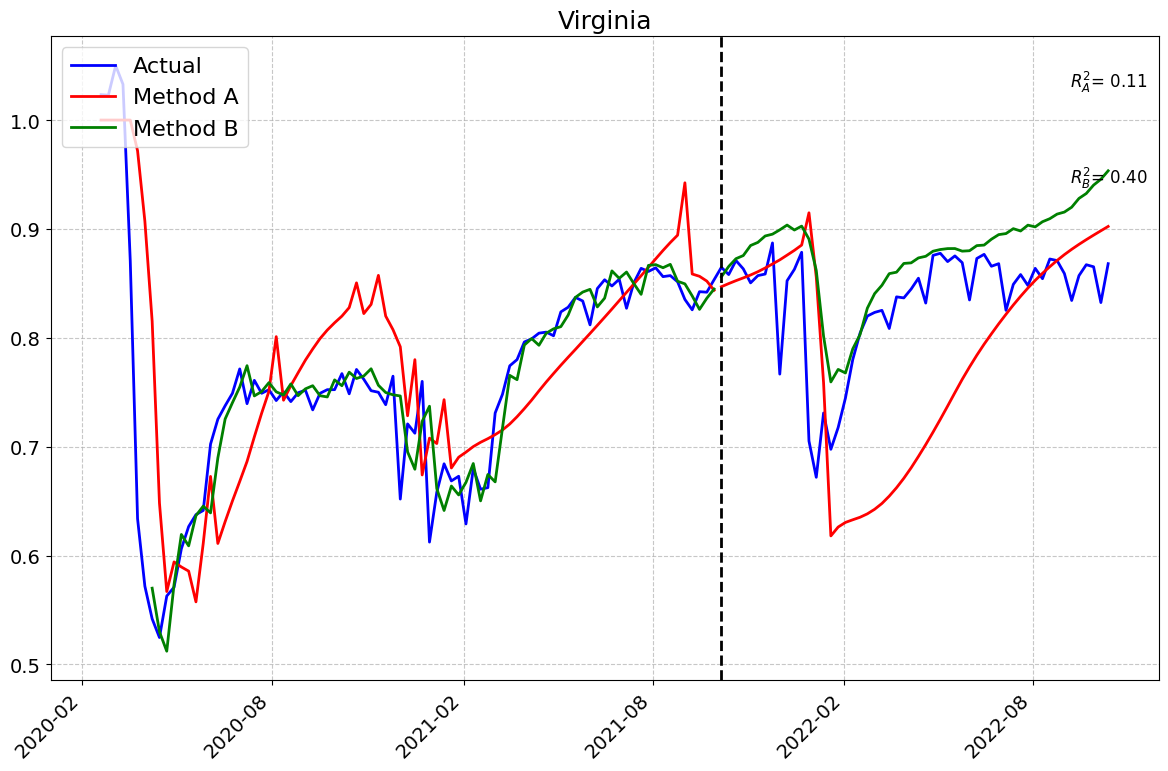

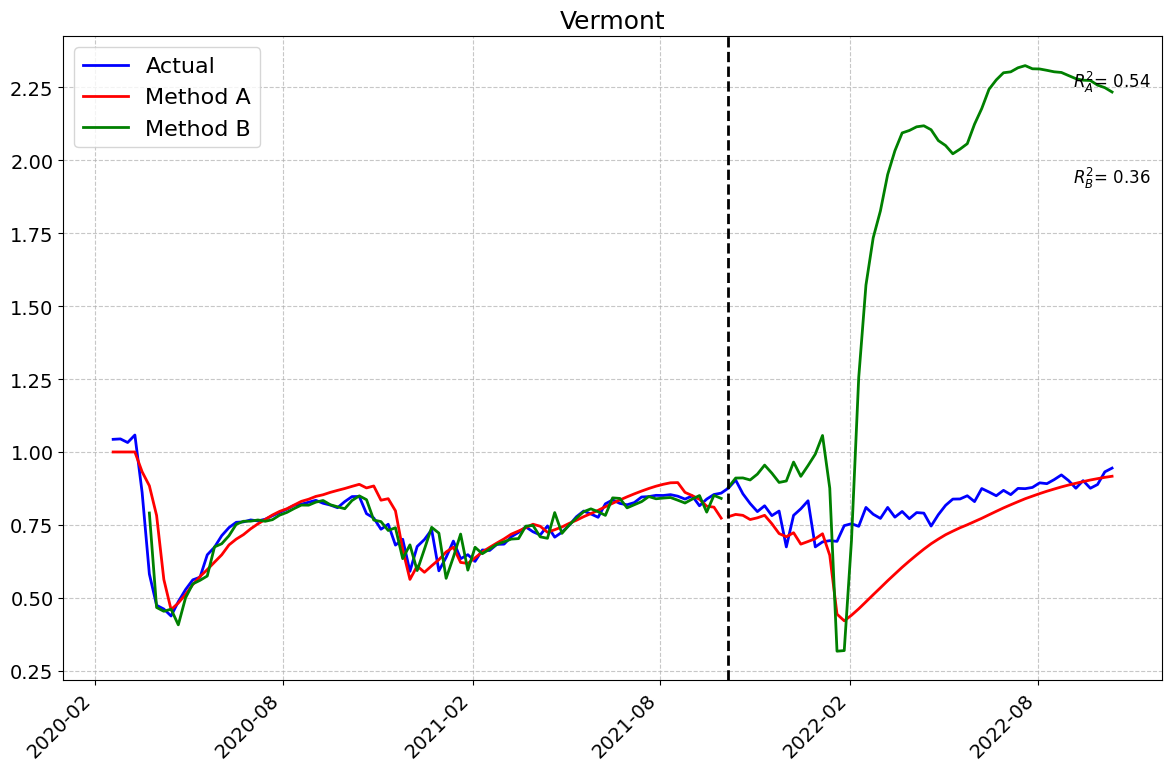

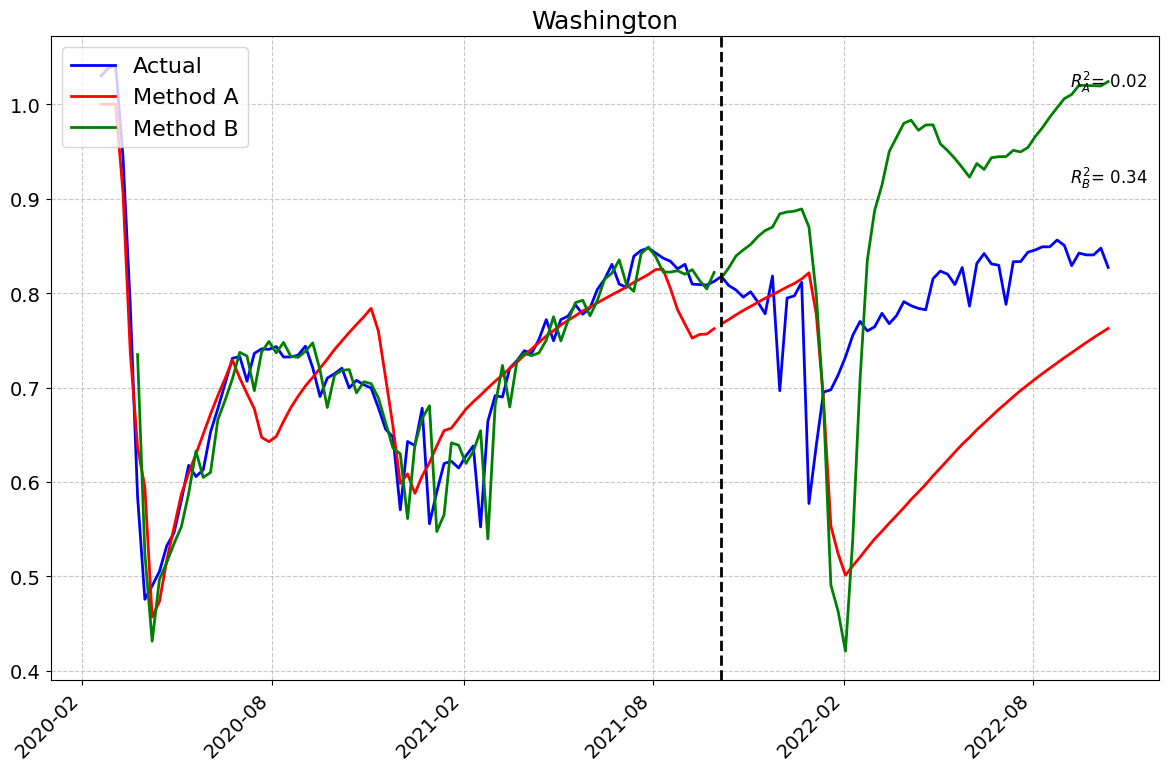

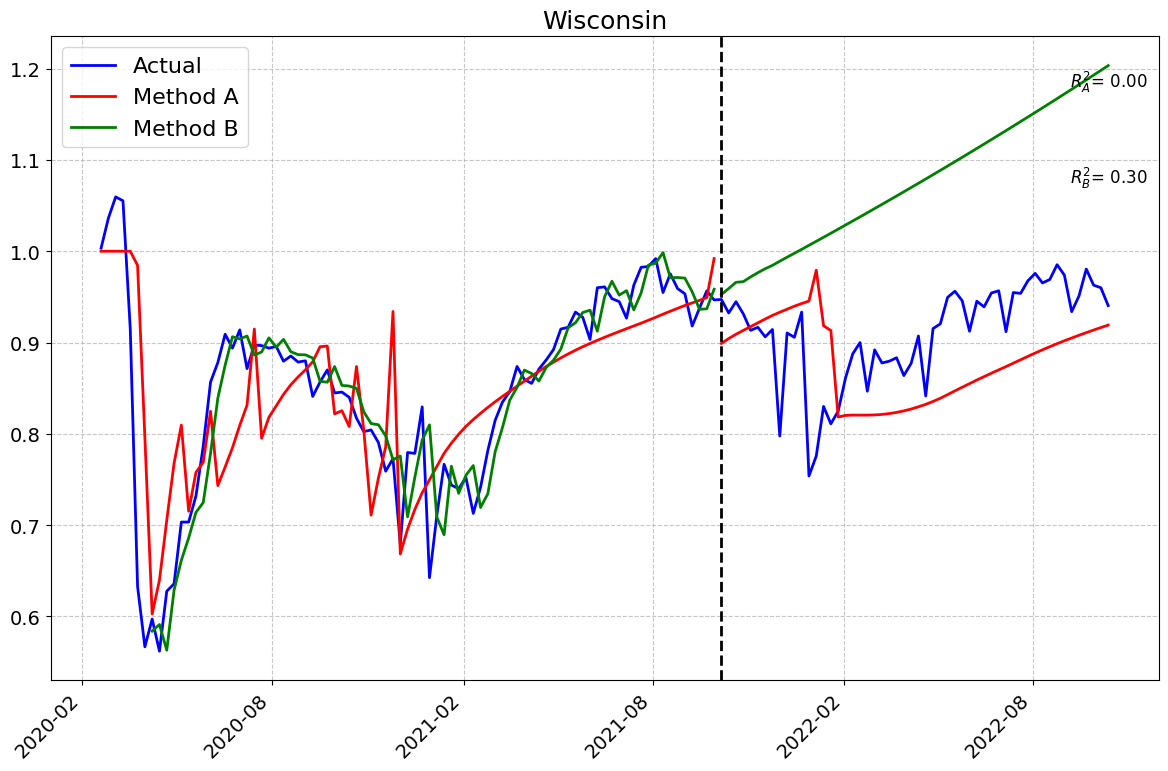

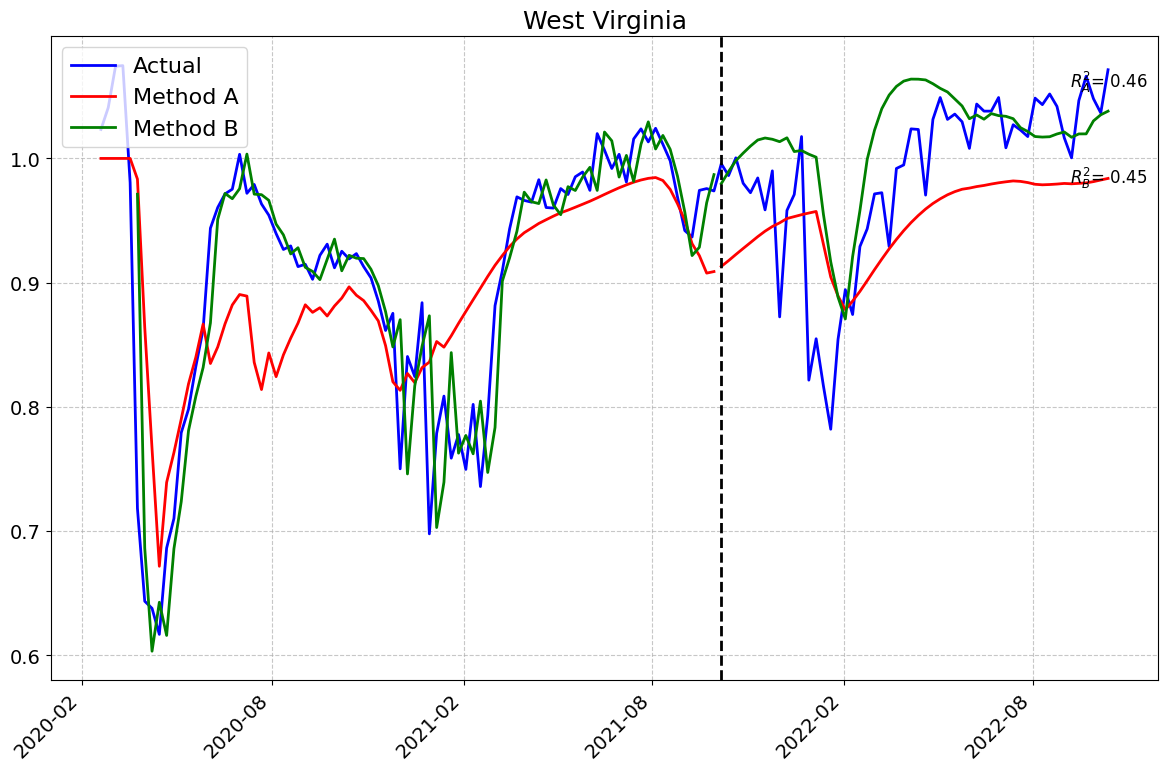

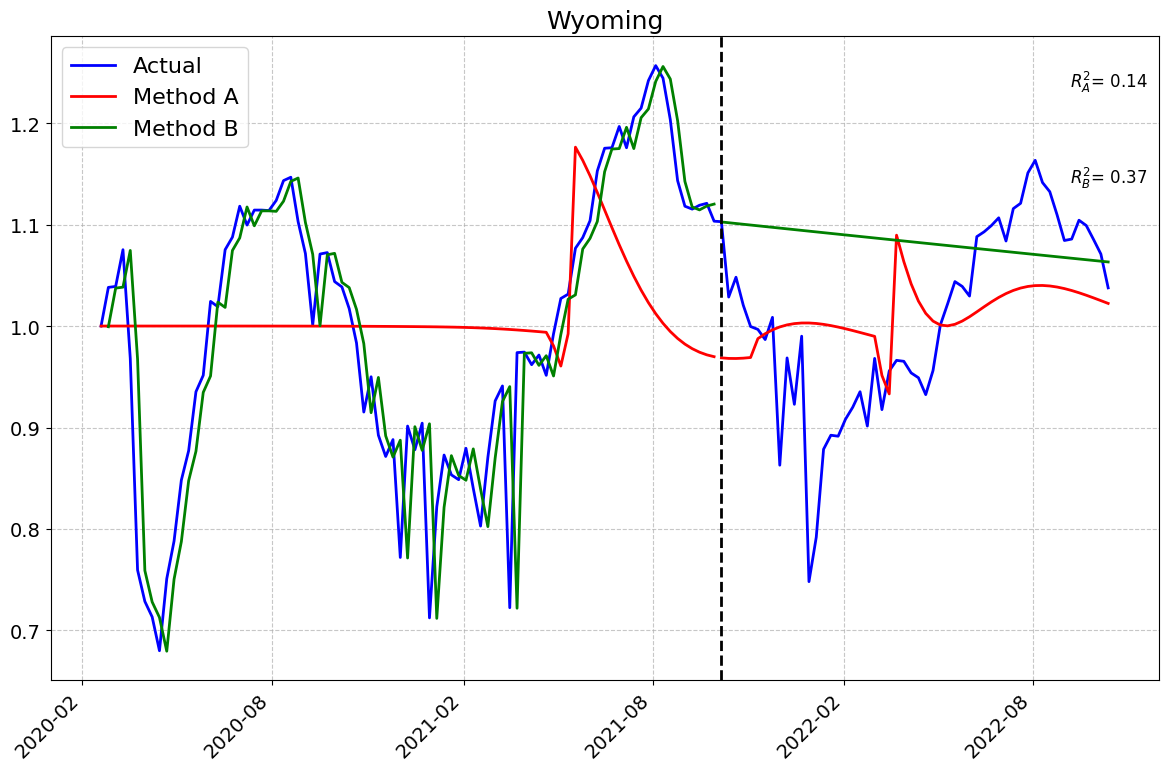

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Increase font sizes globally
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 16

# Prepare a DataFrame to compare test R² for Method A vs. Method B
comparison_df = pd.DataFrame(
    index=range(51),
    columns=['methodA_r2_test', 'methodB_r2_test']
)

# Example vertical line date
vertical_line_date = pd.to_datetime('2021-10-06')

# Loop through each state to create separate figures
for s in range(51):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # ------------------------ Method A Computations ---------------------------
    values = state_dict[s].copy()  # Full data for state s
    d1 = answers_asy_test['best_delay1'][s]
    d2 = answers_asy_test['best_delay2'][s]
    o = int(round(answers_asy_test['best_order'][s]))  # ensure integer
    alpha = answers_asy_test['best_alpha'][s]
    best_k = answers_asy_test['best_k'][s]

    df_A = values.reset_index(drop=True)
    
    # Create shifted columns based on the order 'o' for B_est
    for i in range(o + 1):
        column_name = f"B_est_{i}"
        df_A[column_name] = df_A["case_rate"].astype(float)

    # Apply the asymmetric delay logic
    for i in range(len(df_A["case_rate"]) - 1):
        if df_A.loc[i, 'case_rate'] < df_A.loc[i, f'B_est_{o}']:
            d = d2
        else:
            d = d1
        for j in range(1, o + 1):
            prev_column = f'B_est_{j-1}'
            current_column = f'B_est_{j}'
            df_A.loc[i + 1, current_column] = (
                df_A.loc[i, current_column] +
                (df_A.loc[i, prev_column] - df_A.loc[i, current_column]) / (d / o)
            )

    # Compute Method A's predicted mobility
    denominator = df_A['cumulative_case_rate'].copy()
    denominator[denominator == 0] = 1  # avoid divide-by-zero
    mob_pred_A = np.exp(best_k * df_A[f"B_est_{o}"] / (denominator ** (alpha / 100)))

    # Convert back to time-index
    df_plot_A = values.copy()
    df_plot_A.reset_index(inplace=True)
    df_plot_A['date'] = pd.to_datetime(df_plot_A['date'])
    df_plot_A.set_index('date', inplace=True)

    # Split first 85 rows as training, rest as test
    train_end_index = 85
    actual_mob = df_plot_A['mobility']
    fitted_mob_A = mob_pred_A.iloc[:train_end_index]    # Method A's in-sample
    projected_mob_A = mob_pred_A.iloc[train_end_index:]   # Method A's out-of-sample

    # Align indexes for plotting
    fitted_mob_A.index = df_plot_A.index[:train_end_index]
    projected_mob_A.index = df_plot_A.index[train_end_index:]
    
    # ------------------------ Method B (New ARDL/OLS) ---------------------------
    model_info = results_dict_ols[s]
    if model_info is None:
        fitted_values_B = pd.Series(dtype=float)
        fitted_index_B = pd.DatetimeIndex([])
        projected_B = pd.Series(dtype=float)
    else:
        # Unpack the model and lags
        ols_model_B = model_info['model']
        p = model_info['p']
        q = model_info['q']
        
        # Rebuild the training data to align with the model's fitted values
        df_train_B = train_dict[s].copy()
        df_train_B.sort_index(inplace=True)
        
        # Create p lags of mobility
        for i in range(1, p + 1):
            df_train_B[f'mobility_t-{i}'] = df_train_B['mobility'].shift(i)
        # Create q lags of case_rate
        for j in range(1, q + 1):
            df_train_B[f'case_rate_t-{j}'] = df_train_B['case_rate'].shift(j)
        
        df_train_B.dropna(inplace=True)
        
        # In-sample fitted values
        fitted_values_B = ols_model_B.fittedvalues
        fitted_index_B = df_train_B.index
        # Out-of-sample forecast
        projected_B = predictions_dict[s]
    
    # For test R², we need the test data
    test_data_B = test_dict[s].copy()
    test_data_B.sort_index(inplace=True)
    projected_B = projected_B.reindex(test_data_B.index, fill_value=np.nan)

    # ----------------------- Plot on the Same Axes ---------------------------
    # 1) Actual mobility
    ax.plot(
        values.index,
        values['mobility'],
        label='Actual',
        color='blue',
        linewidth=2
    )

    # 2) Method A (fitted + projected)
    ax.plot(
        fitted_mob_A.index, fitted_mob_A,
        label='Method A',
        color='red',
        linewidth=2
    )
    ax.plot(
        projected_mob_A.index, projected_mob_A,
        label='_nolegend_',
        color='red',
        linewidth=2
    )

    # 3) Method B (fitted + projected)
    ax.plot(
        fitted_index_B, fitted_values_B,
        label='Method B',
        color='green',
        linewidth=2
    )
    ax.plot(
        projected_B.index, projected_B,
        label='_nolegend_',
        color='green',
        linewidth=2
    )

    # Vertical line for reference
    ax.axvline(x=vertical_line_date, color='black', linestyle='--', linewidth=2)

    # ---------------------- Compute R² (Test) ----------------------
    # Method A R²
    mob_actual_test_A = df_plot_A['mobility'].iloc[train_end_index:]
    mob_actual_test_A = mob_actual_test_A.reindex(projected_mob_A.index)
    if len(mob_actual_test_A) > 1:
        corr_matrix_A = np.corrcoef(projected_mob_A, mob_actual_test_A)
        r2_A = corr_matrix_A[0, 1] ** 2
    else:
        r2_A = np.nan

    # Method B R²
    y_test_actual_B = test_data_B['mobility'].copy()
    y_test_pred_B = projected_B.copy()
    y_test_pred_B = y_test_pred_B.reindex(y_test_actual_B.index)
    if len(y_test_actual_B) > 1:
        corr_matrix_B = np.corrcoef(y_test_pred_B, y_test_actual_B)
        r2_B = corr_matrix_B[0, 1] ** 2
    else:
        r2_B = np.nan

    # Store these values in comparison_df
    comparison_df.loc[s, 'methodA_r2_test'] = r2_A
    comparison_df.loc[s, 'methodB_r2_test'] = r2_B

    # Display R² values on the plot
    ax.text(
        0.99, 0.95,
        f'$R^2_{{A}}$= {r2_A:.2f}',
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        horizontalalignment='right'
    )
    ax.text(
        0.99, 0.80,
        f'$R^2_{{B}}$= {r2_B:.2f}',
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        horizontalalignment='right'
    )

    # Set subplot title using state name
    if 'state_full_name' in values.columns:
        state_name = values["state_full_name"].iloc[0]
    else:
        state_name = f"State {s}"
    ax.set_title(f'{state_name}')

    # Format the x-axis dates
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='upper left')

    plt.tight_layout()
    plt.show()
